# Set Environment

In [1]:
import copy
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Preprocessing Functions

In [2]:
def dropStartingNa(dat: pd.DataFrame) -> pd.DataFrame:
  if 'GDP(SA)' in dat.columns:
    tempData = dat.drop(columns=['GDP(SA)'])
  else:
    tempData = dat

  dropIndex = []
  i = 0
  while i < len(dat) and any(tempData.iloc[i].isna()):
      dropIndex.append(dat.index[i])
      i += 1
  return dat.drop(index=dropIndex)

In [3]:
def convertToQuarterlyMean(dat: pd.DataFrame) -> pd.DataFrame:
    return dat.groupby(dat.index.asfreq('Q')).mean()

# BEM Models

In [4]:
def hamiltonFilterDF(data: pd.DataFrame) -> pd.DataFrame:
  data = copy.deepcopy(data)
  data = data.apply(hamiltonFilterSeries)
  return data

In [5]:
def hamiltonFilterSeries(series: pd.Series) -> pd.Series:
  series = copy.deepcopy(series)
  seriesNonNa = series.dropna()
  filteredSeriesNonNa = pd.Series(data=hamilton_filter(seriesNonNa, h=3, p=2)[0], index=seriesNonNa.index, name=seriesNonNa.name)

  return filteredSeriesNonNa.reindex(series.index)

In [6]:
def hamilton_filter(data, h, p=None):
    """
    This function applies "Hamilton filter" to the data

    http://econweb.ucsd.edu/~jhamilto/hp.pdf

    Parameters
    ----------
    data : array or dataframe
    h : integer
        Time horizon that we are likely to predict incorrectly.
        Original paper recommends 2 for annual data, 8 for quarterly data,
        24 for monthly data.
    p : integer (optional)
        If supplied, it is p in the paper. Number of lags in regression.
        If not supplied, random walk process is assumed.

    Returns
    -------
    cycle : array of cyclical component
    trend : trend component

    Notes
    -----
    For seasonal data, it's desirable for p and h to be integer multiples of
    the number of obsevations in a year. E.g. for quarterly data, h = 8 and p =
    4 are recommended.

    """
    # transform data to array
    y = np.asarray(data, float)
    # sample size
    T = len(y)

    if p is not None:  # if p is supplied
        # construct X matrix of lags
        X = np.ones((T-p-h+1, p+1))
        for j in range(1, p+1):
            X[:, j] = y[p-j:T-h-j+1:1]

        # do OLS regression
        b = np.linalg.solve(X.transpose()@X, X.transpose()@y[p+h-1:T])
        # trend component (`nan` for the first p+h-1 period)
        trend = np.append(np.zeros(p+h-1)+np.nan, X@b)
        # cyclical component
        cycle = y - trend
    else:  # if p is not supplied (random walk)
        cycle = np.append(np.zeros(h)+np.nan, y[h:T] - y[0:T-h])
        trend = y - cycle
    return cycle, trend

In [32]:
def kalmanState(data: pd.DataFrame, end:str) -> np.ndarray:
  mod = DynamicFactorMQ(data, factor_orders=2)
  res = mod.fit()
  factors = copy.deepcopy(res.factors['smoothed'])
  factors.columns = ['Factor']
  factors = factors.reindex(pd.period_range(start=factors.index[0], end=pd.Period(end, freq='Q-DEC'), freq='M'))
  for i, m in enumerate(factors.index):
    if np.isnan(factors['Factor'].iloc[i]):
      # factors['Factor'].iloc[i] = res.params['L1.0->0'] * factors['Factor'].iloc[i - 1] + res.params['L2.0->0'] * factors['Factor'].iloc[i - 2]
      factors.loc[m, 'Factor'] = res.params['L1.0->0'] * factors['Factor'].iloc[i - 1] + res.params['L2.0->0'] * factors['Factor'].iloc[i - 2]
  return factors

In [35]:
def bem1(data: pd.DataFrame, end: str) -> pd.Series:
  target, Xs = copy.deepcopy(data['GDP(SA)']), copy.deepcopy(data.drop(columns=['GDP(SA)']))

  filteredXs = hamiltonFilterDF(np.log(Xs)).iloc[5:]
  factors = kalmanState(data=filteredXs, end=end)
  querterlyFactors = convertToQuarterlyMean(factors)

  logTarget = np.log(target)
  querterlyLogTarget = convertToQuarterlyMean(logTarget)
  querterlyLogTarget = querterlyLogTarget.reindex(pd.period_range(start=querterlyLogTarget.index[0], end=end, freq='Q-DEC'))

  targetARresult = ARIMA(endog=querterlyLogTarget, order=(2,0,0), trend='ct', enforce_stationarity=False, enforce_invertibility=False).fit()

  uARresult = ARIMA(endog=targetARresult.resid.loc['2001Q1':], exog=querterlyFactors.loc['2001Q1':], order=(1,0,0), trend='n').fit()
  finalTargetPredict = targetARresult.predict(start='2001Q1', end=end) + uARresult.predict(start='2001Q1', end=end)

  return querterlyLogTarget.fillna(finalTargetPredict)

In [ ]:
def bem2(data: pd.DataFrame, end: str) -> pd.Series:
  target, Xs = copy.deepcopy(data['GDP(SA)']), copy.deepcopy(data.drop(columns=['GDP(SA)']))

  filteredXs = hamiltonFilterDF(np.log(Xs)).iloc[5:]
  factors = kalmanState(data=filteredXs, end=end)
  querterlyFactors = convertToQuarterlyMean(factors)

  logTarget = np.log(target)
  querterlyLogTarget = convertToQuarterlyMean(logTarget)
  querterlyLogTarget = querterlyLogTarget.reindex(pd.period_range(start=querterlyLogTarget.index[0], end=end, freq='Q-DEC'))

  targetARresult = ARIMA(endog=querterlyLogTarget.loc['2000Q3':], exog=querterlyFactors.loc['2000Q3':], order=(2,0,0), trend='ct', enforce_stationarity=False, enforce_invertibility=False).fit()

  uARresult = ARIMA(endog=targetARresult.resid.loc['2001Q1':], order=(1,0,0), trend='n').fit()
  finalTargetPredict = targetARresult.predict(start='2001Q1', end=end) + uARresult.predict(start='2001Q1', end=end)

  return querterlyLogTarget.fillna(finalTargetPredict)

# Vintage

In [10]:
fullData = pd.read_csv('2024-01-04.csv', index_col=0)
fullData.index = pd.PeriodIndex(fullData.index, freq='M')
fullData = fullData[['GDP(SA)', '전산업생산지수(SA)', '일평균수출(실질, SA)', 'NSI']]

In [11]:
vintage_dict = dict()

In [12]:
test_dates = [x for x in fullData.index if '2022-12'>=str(x)>='2007-01' and int(str(x)[-2:])%3==0]

In [13]:
test_dates

[Period('2007-03', 'M'),
 Period('2007-06', 'M'),
 Period('2007-09', 'M'),
 Period('2007-12', 'M'),
 Period('2008-03', 'M'),
 Period('2008-06', 'M'),
 Period('2008-09', 'M'),
 Period('2008-12', 'M'),
 Period('2009-03', 'M'),
 Period('2009-06', 'M'),
 Period('2009-09', 'M'),
 Period('2009-12', 'M'),
 Period('2010-03', 'M'),
 Period('2010-06', 'M'),
 Period('2010-09', 'M'),
 Period('2010-12', 'M'),
 Period('2011-03', 'M'),
 Period('2011-06', 'M'),
 Period('2011-09', 'M'),
 Period('2011-12', 'M'),
 Period('2012-03', 'M'),
 Period('2012-06', 'M'),
 Period('2012-09', 'M'),
 Period('2012-12', 'M'),
 Period('2013-03', 'M'),
 Period('2013-06', 'M'),
 Period('2013-09', 'M'),
 Period('2013-12', 'M'),
 Period('2014-03', 'M'),
 Period('2014-06', 'M'),
 Period('2014-09', 'M'),
 Period('2014-12', 'M'),
 Period('2015-03', 'M'),
 Period('2015-06', 'M'),
 Period('2015-09', 'M'),
 Period('2015-12', 'M'),
 Period('2016-03', 'M'),
 Period('2016-06', 'M'),
 Period('2016-09', 'M'),
 Period('2016-12', 'M'),


In [14]:
for test_date in test_dates:
    temp_dat = copy.deepcopy(fullData)
    temp_dat = temp_dat.loc[:test_date]

    for col in ['GDP(SA)', '전산업생산지수(SA)']:
        temp_dat.loc[test_date, col] = np.nan

    vintage_dict[test_date] = temp_dat

In [15]:
vintage_dict[pd.Period('2016-03', 'M')]

,GDP(SA),전산업생산지수(SA),"일평균수출(실질, SA)",NSI
2000-01,NaN,52.5,8.575735e+05,NaN
2000-02,NaN,52.5,9.208497e+05,NaN
2000-03,220786.3,53.6,9.157984e+05,NaN
2000-04,NaN,53.5,9.982122e+05,NaN
2000-05,NaN,54.9,1.010233e+06,NaN
...,...,...,...,...
2015-11,NaN,94.0,2.052452e+06,106.13
2015-12,420167.6,94.6,1.874112e+06,101.40
2016-01,NaN,93.5,1.809522e+06,96.32
2016-02,NaN,94.7,1.876428e+06,94.67


In [16]:
predNow = pd.DataFrame(index=pd.period_range(start='2007Q1', end='2015Q4', freq='Q-DEC'), columns=['BEM1', 'BEM2'])
pred1qa = pd.DataFrame(index=pd.period_range(start='2007Q1', end='2016Q1', freq='Q-DEC'), columns=['BEM1', 'BEM2'])

In [36]:
for test_date, data in vintage_dict.items():
  now=str(test_date.asfreq('Q-DEC'))
  aqa=str(test_date.asfreq('Q-DEC') + 1)

  predNow.loc[now, 'BEM1'] = bem1(data, now).diff().iloc[-1]*100
  pred1qa.loc[aqa, 'BEM1'] = bem1(data, aqa).diff().iloc[-1]*100

  
  predNow.loc[now, 'BEM2'] = bem2(data, now).diff().iloc[-1]*100
  pred1qa.loc[aqa, 'BEM2'] = bem2(data, aqa).diff().iloc[-1]*100

          Factor
2000Q2  4.535107
2000Q3  0.799530
2000Q4 -2.286625
2001Q1 -0.527293
2001Q2  0.501130
2001Q3 -0.101966
2001Q4  0.050605
2002Q1  0.958855
2002Q2  0.850993
2002Q3 -0.064529
2002Q4 -0.314854
2003Q1 -0.968797
2003Q2 -0.170486
2003Q3  0.192626
2003Q4  0.137026
2004Q1  0.402940
2004Q2 -0.406764
2004Q3 -1.010568
2004Q4 -0.408872
2005Q1  0.710141
2005Q2 -0.243447
2005Q3  0.299494
2005Q4  0.915661
2006Q1  0.188487
2006Q2 -0.426883
2006Q3 -0.233935
2006Q4  1.509205
2007Q1 -0.604383
          Factor
2000Q2  4.535107
2000Q3  0.799530
2000Q4 -2.286625
2001Q1 -0.527293
2001Q2  0.501130
2001Q3 -0.101966
2001Q4  0.050605
2002Q1  0.958855
2002Q2  0.850993
2002Q3 -0.064529
2002Q4 -0.314854
2003Q1 -0.968797
2003Q2 -0.170486
2003Q3  0.192626
2003Q4  0.137026
2004Q1  0.402940
2004Q2 -0.406764
2004Q3 -1.010568
2004Q4 -0.408872
2005Q1  0.710141
2005Q2 -0.243447
2005Q3  0.299494
2005Q4  0.915661
2006Q1  0.188487
2006Q2 -0.426883
2006Q3 -0.233935
2006Q4  1.509205
2007Q1 -0.604383
2007Q2  0.1004

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2  4.933557
2000Q3  1.145166
2000Q4 -1.978997
2001Q1 -0.378900
2001Q2  0.376544
2001Q3 -0.124939
2001Q4 -0.008438
2002Q1  0.786997
2002Q2  0.683366
2002Q3 -0.063803
2002Q4 -0.223286
2003Q1 -0.787756
2003Q2 -0.135204
2003Q3  0.185399
2003Q4  0.128551
2004Q1  0.380080
2004Q2 -0.349182
2004Q3 -0.847767
2004Q4 -0.309910
2005Q1  0.618053
2005Q2 -0.328310
2005Q3  0.205061
2005Q4  0.735364
2006Q1  0.119464
2006Q2 -0.454019
2006Q3 -0.329129
2006Q4  1.132409
2007Q1 -0.690961
2007Q2  0.146480
2007Q3  0.721992
          Factor
2000Q2  4.933557
2000Q3  1.145166
2000Q4 -1.978997
2001Q1 -0.378900
2001Q2  0.376544
2001Q3 -0.124939
2001Q4 -0.008438
2002Q1  0.786997
2002Q2  0.683366
2002Q3 -0.063803
2002Q4 -0.223286
2003Q1 -0.787756
2003Q2 -0.135204
2003Q3  0.185399
2003Q4  0.128551
2004Q1  0.380080
2004Q2 -0.349182
2004Q3 -0.847767
2004Q4 -0.309910
2005Q1  0.618053
2005Q2 -0.328310
2005Q3  0.205061
2005Q4  0.735364
2006Q1  0.119464
2006Q2 -0.454019
2006Q3 -0.329129
2006Q4  1.1324

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2  2.257594
2000Q3  0.347363
2000Q4 -2.836802
2001Q1 -0.546929
2001Q2  1.153269
2001Q3 -0.009571
2001Q4  0.313931
2002Q1  1.422310
2002Q2  1.103568
2002Q3 -0.146434
2002Q4 -0.526920
2003Q1 -1.460592
2003Q2 -0.230891
2003Q3 -0.002488
2003Q4 -0.005696
2004Q1  0.212668
2004Q2 -0.650827
2004Q3 -1.502961
2004Q4 -0.812660
2005Q1  0.734989
2005Q2 -0.221047
2005Q3  0.195610
2005Q4  0.843016
2006Q1 -0.049819
2006Q2 -0.248664
2006Q3 -0.573651
2006Q4  2.075669
2007Q1 -0.816471
2007Q2 -0.093448
2007Q3  1.204375
2007Q4  0.664569
          Factor
2000Q2  2.257594
2000Q3  0.347363
2000Q4 -2.836802
2001Q1 -0.546929
2001Q2  1.153269
2001Q3 -0.009571
2001Q4  0.313931
2002Q1  1.422310
2002Q2  1.103568
2002Q3 -0.146434
2002Q4 -0.526920
2003Q1 -1.460592
2003Q2 -0.230891
2003Q3 -0.002488
2003Q4 -0.005696
2004Q1  0.212668
2004Q2 -0.650827
2004Q3 -1.502961
2004Q4 -0.812660
2005Q1  0.734989
2005Q2 -0.221047
2005Q3  0.195610
2005Q4  0.843016
2006Q1 -0.049819
2006Q2 -0.248664
2006Q3 -0.5736

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2  2.316972
2000Q3  0.372033
2000Q4 -2.772336
2001Q1 -0.514818
2001Q2  1.152806
2001Q3  0.012317
2001Q4  0.326943
2002Q1  1.405034
2002Q2  1.090562
2002Q3 -0.146321
2002Q4 -0.526303
2003Q1 -1.446760
2003Q2 -0.234840
2003Q3 -0.007811
2003Q4 -0.019976
2004Q1  0.196723
2004Q2 -0.660923
2004Q3 -1.499023
2004Q4 -0.819926
2005Q1  0.702432
2005Q2 -0.244762
2005Q3  0.166393
2005Q4  0.802355
2006Q1 -0.081520
2006Q2 -0.296911
2006Q3 -0.598458
2006Q4  1.999380
2007Q1 -0.862753
2007Q2 -0.139694
2007Q3  1.124774
2007Q4  0.777835
2008Q1 -0.208426
          Factor
2000Q2  2.316972
2000Q3  0.372033
2000Q4 -2.772336
2001Q1 -0.514818
2001Q2  1.152806
2001Q3  0.012317
2001Q4  0.326943
2002Q1  1.405034
2002Q2  1.090562
2002Q3 -0.146321
2002Q4 -0.526303
2003Q1 -1.446760
2003Q2 -0.234840
2003Q3 -0.007811
2003Q4 -0.019976
2004Q1  0.196723
2004Q2 -0.660923
2004Q3 -1.499023
2004Q4 -0.819926
2005Q1  0.702432
2005Q2 -0.244762
2005Q3  0.166393
2005Q4  0.802355
2006Q1 -0.081520
2006Q2 -0.2969

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2  2.257720
2000Q3  0.310171
2000Q4 -2.872985
2001Q1 -0.576091
2001Q2  1.124446
2001Q3 -0.033096
2001Q4  0.296707
2002Q1  1.413964
2002Q2  1.095974
2002Q3 -0.146793
2002Q4 -0.530367
2003Q1 -1.464694
2003Q2 -0.230372
2003Q3 -0.001218
2003Q4 -0.001466
2004Q1  0.224598
2004Q2 -0.643466
2004Q3 -1.492983
2004Q4 -0.806695
2005Q1  0.753415
2005Q2 -0.201692
2005Q3  0.217598
2005Q4  0.876795
2006Q1 -0.021657
2006Q2 -0.223221
2006Q3 -0.542217
2006Q4  2.112955
2007Q1 -0.765685
2007Q2 -0.042026
2007Q3  1.252602
2007Q4  0.901136
2008Q1  0.000798
2008Q2 -1.184493
          Factor
2000Q2  2.257720
2000Q3  0.310171
2000Q4 -2.872985
2001Q1 -0.576091
2001Q2  1.124446
2001Q3 -0.033096
2001Q4  0.296707
2002Q1  1.413964
2002Q2  1.095974
2002Q3 -0.146793
2002Q4 -0.530367
2003Q1 -1.464694
2003Q2 -0.230372
2003Q3 -0.001218
2003Q4 -0.001466
2004Q1  0.224598
2004Q2 -0.643466
2004Q3 -1.492983
2004Q4 -0.806695
2005Q1  0.753415
2005Q2 -0.201692
2005Q3  0.217598
2005Q4  0.876795
2006Q1 -0.0216

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-281.81, convergence criterion=4.0349e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_f

          Factor
2000Q2 -2.712738
2000Q3 -0.188422
2000Q4  3.100253
2001Q1  0.683490
2001Q2 -1.077466
2001Q3  0.097112
2001Q4 -0.252731
2002Q1 -1.453050
2002Q2 -1.118641
2002Q3  0.148894
2002Q4  0.550441
2003Q1  1.524868
2003Q2  0.224515
2003Q3 -0.024697
2003Q4 -0.028791
2004Q1 -0.285898
2004Q2  0.631225
2004Q3  1.504955
2004Q4  0.796806
2005Q1 -0.858675
2005Q2  0.159366
2005Q3 -0.323092
2005Q4 -1.000549
2006Q1 -0.084096
2006Q2  0.135606
2006Q3  0.397868
2006Q4 -2.335219
2007Q1  0.648148
2007Q2 -0.134740
2007Q3 -1.471232
2007Q4 -1.136944
2008Q1 -0.191343
2008Q2  1.147012
2008Q3  1.100722


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-281.81, convergence criterion=4.0349e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -2.712738
2000Q3 -0.188422
2000Q4  3.100253
2001Q1  0.683490
2001Q2 -1.077466
2001Q3  0.097112
2001Q4 -0.252731
2002Q1 -1.453050
2002Q2 -1.118641
2002Q3  0.148894
2002Q4  0.550441
2003Q1  1.524868
2003Q2  0.224515
2003Q3 -0.024697
2003Q4 -0.028791
2004Q1 -0.285898
2004Q2  0.631225
2004Q3  1.504955
2004Q4  0.796806
2005Q1 -0.858675
2005Q2  0.159366
2005Q3 -0.323092
2005Q4 -1.000549
2006Q1 -0.084096
2006Q2  0.135606
2006Q3  0.397868
2006Q4 -2.335219
2007Q1  0.648148
2007Q2 -0.134740
2007Q3 -1.471232
2007Q4 -1.136944
2008Q1 -0.191343
2008Q2  1.147012
2008Q3  1.100722
2008Q4 -0.034710
          Factor
2000Q2 -4.352258
2000Q3 -0.485810
2000Q4  2.331737
2001Q1  0.754176
2001Q2 -0.287010
2001Q3  0.154944
2001Q4 -0.076286
2002Q1 -1.008634
2002Q2 -0.824497
2002Q3  0.011848
2002Q4  0.429745
2003Q1  1.071209
2003Q2  0.236851
2003Q3 -0.189366
2003Q4 -0.192180
2004Q1 -0.435149
2004Q2  0.454136
2004Q3  1.035345
2004Q4  0.423673
2005Q1 -0.774415
2005Q2  0.257571
2005Q3 -0.4774

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -4.478385
2000Q3 -0.457605
2000Q4  2.089089
2001Q1  0.790330
2001Q2  0.077241
2001Q3  0.388492
2001Q4  0.102510
2002Q1 -0.813110
2002Q2 -0.597417
2002Q3 -0.029742
2002Q4  0.296235
2003Q1  0.887323
2003Q2  0.126481
2003Q3 -0.269832
2003Q4 -0.326362
2004Q1 -0.561028
2004Q2  0.271746
2004Q3  0.733005
2004Q4  0.205217
2005Q1 -0.851679
2005Q2  0.246662
2005Q3 -0.545146
2005Q4 -0.825496
2006Q1 -0.361113
2006Q2 -0.084739
2006Q3 -0.253710
2006Q4 -1.666641
2007Q1  0.093910
2007Q2 -0.494105
2007Q3 -1.232833
2007Q4 -1.178264
2008Q1 -0.601668
2008Q2  0.058570
2008Q3  0.169612
2008Q4  3.393316
2009Q1  1.051867
          Factor
2000Q2 -4.478385
2000Q3 -0.457605
2000Q4  2.089089
2001Q1  0.790330
2001Q2  0.077241
2001Q3  0.388492
2001Q4  0.102510
2002Q1 -0.813110
2002Q2 -0.597417
2002Q3 -0.029742
2002Q4  0.296235
2003Q1  0.887323
2003Q2  0.126481
2003Q3 -0.269832
2003Q4 -0.326362
2004Q1 -0.561028
2004Q2  0.271746
2004Q3  0.733005
2004Q4  0.205217
2005Q1 -0.851679
2005Q2  0.2466

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -3.687765
2000Q3 -0.285574
2000Q4  2.216931
2001Q1  0.674529
2001Q2 -0.155051
2001Q3  0.301539
2001Q4  0.058921
2002Q1 -0.877028
2002Q2 -0.607696
2002Q3  0.036189
2002Q4  0.355060
2003Q1  0.988064
2003Q2  0.152342
2003Q3 -0.179937
2003Q4 -0.181577
2004Q1 -0.451274
2004Q2  0.365019
2004Q3  0.864021
2004Q4  0.348735
2005Q1 -0.811340
2005Q2  0.266805
2005Q3 -0.467464
2005Q4 -0.803177
2006Q1 -0.267622
2006Q2  0.056716
2006Q3 -0.105933
2006Q4 -1.648621
2007Q1  0.249391
2007Q2 -0.403021
2007Q3 -1.157140
2007Q4 -1.058329
2008Q1 -0.428003
2008Q2  0.316690
2008Q3  0.308138
2008Q4  3.620919
2009Q1  0.634420
2009Q2 -2.081004
          Factor
2000Q2 -3.687765
2000Q3 -0.285574
2000Q4  2.216931
2001Q1  0.674529
2001Q2 -0.155051
2001Q3  0.301539
2001Q4  0.058921
2002Q1 -0.877028
2002Q2 -0.607696
2002Q3  0.036189
2002Q4  0.355060
2003Q1  0.988064
2003Q2  0.152342
2003Q3 -0.179937
2003Q4 -0.181577
2004Q1 -0.451274
2004Q2  0.365019
2004Q3  0.864021
2004Q4  0.348735
2005Q1 -0.8113

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -1.768244
2000Q3  0.064390
2000Q4  2.628387
2001Q1  0.601846
2001Q2 -0.719992
2001Q3  0.229610
2001Q4 -0.076826
2002Q1 -1.136849
2002Q2 -0.767541
2002Q3  0.154262
2002Q4  0.456382
2003Q1  1.253779
2003Q2  0.162775
2003Q3  0.010485
2003Q4 -0.023618
2004Q1 -0.269503
2004Q2  0.502248
2004Q3  1.145390
2004Q4  0.629384
2005Q1 -0.783809
2005Q2  0.107721
2005Q3 -0.317627
2005Q4 -0.890613
2006Q1 -0.135238
2006Q2 -0.034648
2006Q3  0.192934
2006Q4 -1.982917
2007Q1  0.330784
2007Q2 -0.219833
2007Q3 -1.407624
2007Q4 -1.086679
2008Q1 -0.363373
2008Q2  0.706213
2008Q3  0.497424
2008Q4  4.031264
2009Q1  0.629936
2009Q2 -2.654658
2009Q3 -1.200305


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -1.768244
2000Q3  0.064390
2000Q4  2.628387
2001Q1  0.601846
2001Q2 -0.719992
2001Q3  0.229610
2001Q4 -0.076826
2002Q1 -1.136849
2002Q2 -0.767541
2002Q3  0.154262
2002Q4  0.456382
2003Q1  1.253779
2003Q2  0.162775
2003Q3  0.010485
2003Q4 -0.023618
2004Q1 -0.269503
2004Q2  0.502248
2004Q3  1.145390
2004Q4  0.629384
2005Q1 -0.783809
2005Q2  0.107721
2005Q3 -0.317627
2005Q4 -0.890613
2006Q1 -0.135238
2006Q2 -0.034648
2006Q3  0.192934
2006Q4 -1.982917
2007Q1  0.330784
2007Q2 -0.219833
2007Q3 -1.407624
2007Q4 -1.086679
2008Q1 -0.363373
2008Q2  0.706213
2008Q3  0.497424
2008Q4  4.031264
2009Q1  0.629936
2009Q2 -2.654658
2009Q3 -1.200305
2009Q4  0.297850


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -3.819789
2000Q3 -0.221947
2000Q4  2.244736
2001Q1  0.610965
2001Q2 -0.287322
2001Q3  0.218532
2001Q4 -0.026045
2002Q1 -0.960901
2002Q2 -0.640578
2002Q3  0.051907
2002Q4  0.416671
2003Q1  1.066641
2003Q2  0.181644
2003Q3 -0.128171
2003Q4 -0.112747
2004Q1 -0.374705
2004Q2  0.459854
2004Q3  0.975229
2004Q4  0.462809
2005Q1 -0.750443
2005Q2  0.310054
2005Q3 -0.392472
2005Q4 -0.741678
2006Q1 -0.160764
2006Q2  0.187266
2006Q3  0.001077
2006Q4 -1.566698
2007Q1  0.383128
2007Q2 -0.276674
2007Q3 -1.054123
2007Q4 -0.920264
2008Q1 -0.226436
2008Q2  0.577832
2008Q3  0.601069
2008Q4  3.898054
2009Q1  0.786634
2009Q2 -2.376059
2009Q3 -1.304880
2009Q4 -0.875474
          Factor
2000Q2 -3.819789
2000Q3 -0.221947
2000Q4  2.244736
2001Q1  0.610965
2001Q2 -0.287322
2001Q3  0.218532
2001Q4 -0.026045
2002Q1 -0.960901
2002Q2 -0.640578
2002Q3  0.051907
2002Q4  0.416671
2003Q1  1.066641
2003Q2  0.181644
2003Q3 -0.128171
2003Q4 -0.112747
2004Q1 -0.374705
2004Q2  0.459854
2004Q3  0.9752

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -4.559908
2000Q3 -0.474651
2000Q4  2.094773
2001Q1  0.651243
2001Q2 -0.108793
2001Q3  0.270765
2001Q4  0.018296
2002Q1 -0.897304
2002Q2 -0.610265
2002Q3  0.020996
2002Q4  0.373998
2003Q1  0.985066
2003Q2  0.182761
2003Q3 -0.182278
2003Q4 -0.198912
2004Q1 -0.427893
2004Q2  0.432149
2004Q3  0.907191
2004Q4  0.372035
2005Q1 -0.725399
2005Q2  0.381214
2005Q3 -0.393809
2005Q4 -0.695512
2006Q1 -0.125808
2006Q2  0.211724
2006Q3 -0.010320
2006Q4 -1.413220
2007Q1  0.392827
2007Q2 -0.255386
2007Q3 -0.934750
2007Q4 -0.832480
2008Q1 -0.186509
2008Q2  0.529077
2008Q3  0.687345
2008Q4  3.871717
2009Q1  0.847796
2009Q2 -2.225728
2009Q3 -1.199058
2009Q4 -0.678788
2010Q1 -0.700983
          Factor
2000Q2 -4.559908
2000Q3 -0.474651
2000Q4  2.094773
2001Q1  0.651243
2001Q2 -0.108793
2001Q3  0.270765
2001Q4  0.018296
2002Q1 -0.897304
2002Q2 -0.610265
2002Q3  0.020996
2002Q4  0.373998
2003Q1  0.985066
2003Q2  0.182761
2003Q3 -0.182278
2003Q4 -0.198912
2004Q1 -0.427893
2004Q2  0.4321

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -4.793356
2000Q3 -0.567405
2000Q4  2.052437
2001Q1  0.627066
2001Q2 -0.108447
2001Q3  0.254995
2001Q4  0.002297
2002Q1 -0.911249
2002Q2 -0.615663
2002Q3  0.010622
2002Q4  0.367418
2003Q1  0.973345
2003Q2  0.180940
2003Q3 -0.189160
2003Q4 -0.208274
2004Q1 -0.427249
2004Q2  0.445107
2004Q3  0.913066
2004Q4  0.372662
2005Q1 -0.707767
2005Q2  0.419052
2005Q3 -0.370244
2005Q4 -0.664095
2006Q1 -0.081951
2006Q2  0.257649
2006Q3  0.022315
2006Q4 -1.351620
2007Q1  0.443140
2007Q2 -0.210055
2007Q3 -0.866410
2007Q4 -0.761095
2008Q1 -0.114750
2008Q2  0.587679
2008Q3  0.776003
2008Q4  3.936944
2009Q1  0.882842
2009Q2 -2.166057
2009Q3 -1.129398
2009Q4 -0.598095
2010Q1 -0.765498
2010Q2 -0.811959
          Factor
2000Q2 -4.793356
2000Q3 -0.567405
2000Q4  2.052437
2001Q1  0.627066
2001Q2 -0.108447
2001Q3  0.254995
2001Q4  0.002297
2002Q1 -0.911249
2002Q2 -0.615663
2002Q3  0.010622
2002Q4  0.367418
2003Q1  0.973345
2003Q2  0.180940
2003Q3 -0.189160
2003Q4 -0.208274
2004Q1 -0.4272

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 44. Reverting to the results from EM iteration 43 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 44. Reverting to the results from EM iteration 43 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv

          Factor
2000Q2 -3.486195
2000Q3 -0.389629
2000Q4  2.070303
2001Q1  0.633553
2001Q2 -0.123424
2001Q3  0.261085
2001Q4  0.006882
2002Q1 -0.917607
2002Q2 -0.620858
2002Q3  0.016415
2002Q4  0.373033
2003Q1  0.990017
2003Q2  0.182900
2003Q3 -0.183474
2003Q4 -0.198143
2004Q1 -0.428103
2004Q2  0.446564
2004Q3  0.926337
2004Q4  0.384702
2005Q1 -0.722926
2005Q2  0.419175
2005Q3 -0.372053
2005Q4 -0.676129
2006Q1 -0.087686
2006Q2  0.249638
2006Q3  0.025203
2006Q4 -1.394032
2007Q1  0.445907
2007Q2 -0.219426
2007Q3 -0.891333
2007Q4 -0.786689
2008Q1 -0.131891
2008Q2  0.580811
2008Q3  0.740578
2008Q4  3.958898
2009Q1  0.882081
2009Q2 -2.214815
2009Q3 -1.154887
2009Q4 -0.608164
2010Q1 -0.805047
2010Q2 -0.702737
2010Q3  0.302859
          Factor
2000Q2 -3.486195
2000Q3 -0.389629
2000Q4  2.070303
2001Q1  0.633553
2001Q2 -0.123424
2001Q3  0.261085
2001Q4  0.006882
2002Q1 -0.917607
2002Q2 -0.620858
2002Q3  0.016415
2002Q4  0.373033
2003Q1  0.990017
2003Q2  0.182900
2003Q3 -0.183474
2003Q4 -0.1981

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 44. Reverting to the results from EM iteration 43 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'


          Factor
2000Q2 -4.987355
2000Q3 -0.648055
2000Q4  2.058454
2001Q1  0.681484
2001Q2 -0.017064
2001Q3  0.309334
2001Q4  0.042784
2002Q1 -0.881305
2002Q2 -0.603407
2002Q3  0.004370
2002Q4  0.355525
2003Q1  0.955130
2003Q2  0.183199
2003Q3 -0.208296
2003Q4 -0.243238
2004Q1 -0.459385
2004Q2  0.428171
2004Q3  0.891092
2004Q4  0.339012
2005Q1 -0.721197
2005Q2  0.444151
2005Q3 -0.377405
2005Q4 -0.667766
2006Q1 -0.085819
2006Q2  0.236683
2006Q3  0.000760
2006Q4 -1.356623
2007Q1  0.424236
2007Q2 -0.231605
2007Q3 -0.874758
2007Q4 -0.785347
2008Q1 -0.156087
2008Q2  0.519248
2008Q3  0.732405
2008Q4  3.918149
2009Q1  0.883127
2009Q2 -2.186164
2009Q3 -1.151972
2009Q4 -0.648073
2010Q1 -0.807849
2010Q2 -0.727166
2010Q3  0.482456
2010Q4 -0.112940
          Factor
2000Q2 -4.987355
2000Q3 -0.648055
2000Q4  2.058454
2001Q1  0.681484
2001Q2 -0.017064
2001Q3  0.309334
2001Q4  0.042784
2002Q1 -0.881305
2002Q2 -0.603407
2002Q3  0.004370
2002Q4  0.355525
2003Q1  0.955130
2003Q2  0.183199
2003Q3 -0.2082

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood d

             Factor
2000Q2  1130.458823
2000Q3    -0.124080
2000Q4     1.925516
2001Q1     0.673692
2001Q2     0.049672
2001Q3     0.366811
2001Q4    -0.011144
2002Q1    -0.912431
2002Q2    -0.553776
2002Q3    -0.083689
2002Q4     0.338765
2003Q1     0.954355
2003Q2     0.143572
2003Q3    -0.197073
2003Q4    -0.259169
2004Q1    -0.489440
2004Q2     0.406549
2004Q3     0.863707
2004Q4     0.405616
2005Q1    -0.772205
2005Q2     0.513419
2005Q3    -0.392680
2005Q4    -0.634875
2006Q1    -0.048562
2006Q2     0.199036
2006Q3     0.117966
2006Q4    -1.338005
2007Q1     0.452462
2007Q2    -0.216630
2007Q3    -0.817262
2007Q4    -0.722673
2008Q1    -0.050992
2008Q2     0.572102
2008Q3     0.891670
2008Q4     4.001623
2009Q1     0.897351
2009Q2    -2.053888
2009Q3    -1.131663
2009Q4    -0.652490
2010Q1    -0.753124
2010Q2    -0.662848
2010Q3     0.517474
2010Q4    -0.323634
2011Q1    -0.580564
             Factor
2000Q2  1130.458823
2000Q3    -0.124080
2000Q4     1.925516
2001Q1     0.673692


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -4.239862
2000Q3 -0.398474
2000Q4  2.159929
2001Q1  0.629717
2001Q2 -0.206592
2001Q3  0.213813
2001Q4 -0.038979
2002Q1 -0.961495
2002Q2 -0.674581
2002Q3  0.022887
2002Q4  0.402874
2003Q1  1.036254
2003Q2  0.202105
2003Q3 -0.165400
2003Q4 -0.161817
2004Q1 -0.403337
2004Q2  0.481373
2004Q3  0.992373
2004Q4  0.440358
2005Q1 -0.715984
2005Q2  0.410862
2005Q3 -0.354448
2005Q4 -0.686453
2006Q1 -0.076599
2006Q2  0.285372
2006Q3  0.050613
2006Q4 -1.437009
2007Q1  0.482744
2007Q2 -0.204765
2007Q3 -0.903601
2007Q4 -0.795717
2008Q1 -0.097480
2008Q2  0.656239
2008Q3  0.811651
2008Q4  4.080185
2009Q1  0.962004
2009Q2 -2.286951
2009Q3 -1.193003
2009Q4 -0.585898
2010Q1 -0.804322
2010Q2 -0.698296
2010Q3  0.649982
2010Q4 -0.298678
2011Q1 -0.783178
2011Q2  0.236003
          Factor
2000Q2 -4.239862
2000Q3 -0.398474
2000Q4  2.159929
2001Q1  0.629717
2001Q2 -0.206592
2001Q3  0.213813
2001Q4 -0.038979
2002Q1 -0.961495
2002Q2 -0.674581
2002Q3  0.022887
2002Q4  0.402874
2003Q1  1.0362

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -4.366616
2000Q3 -0.422636
2000Q4  2.158626
2001Q1  0.647144
2001Q2 -0.175653
2001Q3  0.228834
2001Q4 -0.028573
2002Q1 -0.959973
2002Q2 -0.680273
2002Q3  0.018274
2002Q4  0.397005
2003Q1  1.027605
2003Q2  0.202020
2003Q3 -0.177769
2003Q4 -0.182143
2004Q1 -0.416558
2004Q2  0.478652
2004Q3  0.988691
2004Q4  0.427497
2005Q1 -0.715383
2005Q2  0.414271
2005Q3 -0.357252
2005Q4 -0.683481
2006Q1 -0.082029
2006Q2  0.273952
2006Q3  0.043521
2006Q4 -1.429596
2007Q1  0.477763
2007Q2 -0.196509
2007Q3 -0.903890
2007Q4 -0.798506
2008Q1 -0.107635
2008Q2  0.649198
2008Q3  0.808601
2008Q4  4.097811
2009Q1  0.998567
2009Q2 -2.278353
2009Q3 -1.193469
2009Q4 -0.596789
2010Q1 -0.807698
2010Q2 -0.701438
2010Q3  0.641994
2010Q4 -0.307151
2011Q1 -0.787618
2011Q2  0.228425
2011Q3 -0.002064
          Factor
2000Q2 -4.366616
2000Q3 -0.422636
2000Q4  2.158626
2001Q1  0.647144
2001Q2 -0.175653
2001Q3  0.228834
2001Q4 -0.028573
2002Q1 -0.959973
2002Q2 -0.680273
2002Q3  0.018274
2002Q4  0.3970

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -4.398350
2000Q3 -0.426530
2000Q4  2.171163
2001Q1  0.676884
2001Q2 -0.142153
2001Q3  0.242638
2001Q4 -0.005063
2002Q1 -0.942463
2002Q2 -0.686944
2002Q3  0.029310
2002Q4  0.403297
2003Q1  1.023146
2003Q2  0.217315
2003Q3 -0.184537
2003Q4 -0.197118
2004Q1 -0.424570
2004Q2  0.477831
2004Q3  0.987201
2004Q4  0.406664
2005Q1 -0.709516
2005Q2  0.404245
2005Q3 -0.359060
2005Q4 -0.700848
2006Q1 -0.093802
2006Q2  0.285217
2006Q3  0.016736
2006Q4 -1.425716
2007Q1  0.463146
2007Q2 -0.221470
2007Q3 -0.912001
2007Q4 -0.816342
2008Q1 -0.130083
2008Q2  0.621892
2008Q3  0.824486
2008Q4  4.095771
2009Q1  1.011772
2009Q2 -2.300545
2009Q3 -1.216201
2009Q4 -0.625394
2010Q1 -0.828826
2010Q2 -0.723921
2010Q3  0.607281
2010Q4 -0.341564
2011Q1 -0.806801
2011Q2  0.184254
2011Q3  0.077765
2011Q4  0.289037
          Factor
2000Q2 -4.398350
2000Q3 -0.426530
2000Q4  2.171163
2001Q1  0.676884
2001Q2 -0.142153
2001Q3  0.242638
2001Q4 -0.005063
2002Q1 -0.942463
2002Q2 -0.686944
2002Q3  0.0293

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -4.602766
2000Q3 -0.482734
2000Q4  2.149088
2001Q1  0.715845
2001Q2 -0.067885
2001Q3  0.278518
2001Q4  0.022019
2002Q1 -0.914061
2002Q2 -0.676952
2002Q3  0.022128
2002Q4  0.391374
2003Q1  1.001730
2003Q2  0.219641
2003Q3 -0.202073
2003Q4 -0.229505
2004Q1 -0.447162
2004Q2  0.462932
2004Q3  0.964010
2004Q4  0.375218
2005Q1 -0.707703
2005Q2  0.417895
2005Q3 -0.363437
2005Q4 -0.697513
2006Q1 -0.095671
2006Q2  0.274902
2006Q3  0.003604
2006Q4 -1.400816
2007Q1  0.447595
2007Q2 -0.229218
2007Q3 -0.901120
2007Q4 -0.816944
2008Q1 -0.149087
2008Q2  0.582219
2008Q3  0.824260
2008Q4  4.076309
2009Q1  1.030797
2009Q2 -2.277147
2009Q3 -1.215324
2009Q4 -0.656253
2010Q1 -0.830207
2010Q2 -0.738392
2010Q3  0.565343
2010Q4 -0.372623
2011Q1 -0.829972
2011Q2  0.168277
2011Q3  0.064613
2011Q4  0.493724
2012Q1 -0.185708
          Factor
2000Q2 -4.602766
2000Q3 -0.482734
2000Q4  2.149088
2001Q1  0.715845
2001Q2 -0.067885
2001Q3  0.278518
2001Q4  0.022019
2002Q1 -0.914061
2002Q2 -0.6769

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 11. Reverting to the results from EM iteration 10 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 11. Reverting to the results from EM iteration 10 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv

               Factor
2000Q2 -881100.180266
2000Q3      -0.166379
2000Q4       2.051669
2001Q1       0.732765
2001Q2      -0.005675
2001Q3       0.321847
2001Q4       0.018276
2002Q1      -0.908184
2002Q2      -0.646005
2002Q3      -0.010605
2002Q4       0.378765
2003Q1       1.002364
2003Q2       0.207412
2003Q3      -0.207835
2003Q4      -0.245462
2004Q1      -0.474422
2004Q2       0.446328
2004Q3       0.944478
2004Q4       0.380277
2005Q1      -0.741265
2005Q2       0.457659
2005Q3      -0.385528
2005Q4      -0.694411
2006Q1      -0.085724
2006Q2       0.242054
2006Q3       0.035585
2006Q4      -1.402954
2007Q1       0.446501
2007Q2      -0.236682
2007Q3      -0.891114
2007Q4      -0.806284
2008Q1      -0.135801
2008Q2       0.565403
2008Q3       0.846050
2008Q4       4.105551
2009Q1       1.033003
2009Q2      -2.235798
2009Q3      -1.214160
2009Q4      -0.686456
2010Q1      -0.818310
2010Q2      -0.741349
2010Q3       0.542425
2010Q4      -0.374931
2011Q1      -0.853423
2011Q2    

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib

          Factor
2000Q2 -3.441468
2000Q3 -0.007448
2000Q4  2.035346
2001Q1  0.807657
2001Q2  0.140084
2001Q3  0.422573
2001Q4  0.012033
2002Q1 -0.887558
2002Q2 -0.587955
2002Q3 -0.068902
2002Q4  0.387100
2003Q1  1.014304
2003Q2  0.196839
2003Q3 -0.197647
2003Q4 -0.273387
2004Q1 -0.514181
2004Q2  0.420097
2004Q3  0.901780
2004Q4  0.411717
2005Q1 -0.787785
2005Q2  0.475457
2005Q3 -0.435265
2005Q4 -0.696786
2006Q1 -0.108967
2006Q2  0.166812
2006Q3  0.057357
2006Q4 -1.421850
2007Q1  0.383844
2007Q2 -0.291987
2007Q3 -0.919932
2007Q4 -0.839045
2008Q1 -0.136790
2008Q2  0.526195
2008Q3  0.939560
2008Q4  4.112509
2009Q1  1.023155
2009Q2 -2.178261
2009Q3 -1.294389
2009Q4 -0.810010
2010Q1 -0.873466
2010Q2 -0.792854
2010Q3  0.416162
2010Q4 -0.417955
2011Q1 -0.957895
2011Q2  0.164127
2011Q3  0.039849
2011Q4  0.440689
2012Q1 -0.253500
2012Q2  0.226223
2012Q3  0.714842
2012Q4  0.069170
          Factor
2000Q2 -4.707629
2000Q3 -0.481266
2000Q4  2.217703
2001Q1  0.770210
2001Q2 -0.029478
2001Q3  0.3093

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -4.810337
2000Q3 -0.488544
2000Q4  2.250738
2001Q1  0.788800
2001Q2 -0.018604
2001Q3  0.317345
2001Q4  0.051363
2002Q1 -0.927537
2002Q2 -0.702335
2002Q3  0.031547
2002Q4  0.412826
2003Q1  1.042161
2003Q2  0.242733
2003Q3 -0.218671
2003Q4 -0.257533
2004Q1 -0.477156
2004Q2  0.478998
2004Q3  0.998500
2004Q4  0.369726
2005Q1 -0.732117
2005Q2  0.422560
2005Q3 -0.394421
2005Q4 -0.755038
2006Q1 -0.112527
2006Q2  0.292886
2006Q3 -0.024443
2006Q4 -1.450959
2007Q1  0.439114
2007Q2 -0.280582
2007Q3 -0.947762
2007Q4 -0.867568
2008Q1 -0.180011
2008Q2  0.576309
2008Q3  0.893755
2008Q4  4.233401
2009Q1  1.058497
2009Q2 -2.388070
2009Q3 -1.295432
2009Q4 -0.729803
2010Q1 -0.892264
2010Q2 -0.805185
2010Q3  0.529972
2010Q4 -0.441985
2011Q1 -0.893378
2011Q2  0.133373
2011Q3  0.055580
2011Q4  0.464026
2012Q1 -0.274503
2012Q2  0.198203
2012Q3  0.776263
2012Q4 -0.427517
2013Q1 -0.179418
2013Q2  0.471788
          Factor
2000Q2 -4.810337
2000Q3 -0.488544
2000Q4  2.250738
2001Q1  0.7888

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib

            Factor
2000Q2 -187.416220
2000Q3   -0.027780
2000Q4    2.126677
2001Q1    0.844403
2001Q2    0.138368
2001Q3    0.431773
2001Q4    0.009558
2002Q1   -0.918145
2002Q2   -0.614030
2002Q3   -0.064851
2002Q4    0.407551
2003Q1    1.062007
2003Q2    0.209936
2003Q3   -0.202703
2003Q4   -0.274198
2004Q1   -0.527328
2004Q2    0.442879
2004Q3    0.945341
2004Q4    0.432155
2005Q1   -0.812524
2005Q2    0.485011
2005Q3   -0.454263
2005Q4   -0.736718
2006Q1   -0.113655
2006Q2    0.196486
2006Q3    0.061835
2006Q4   -1.473935
2007Q1    0.397088
2007Q2   -0.314344
2007Q3   -0.959884
2007Q4   -0.864897
2008Q1   -0.135840
2008Q2    0.565826
2008Q3    1.007153
2008Q4    4.271226
2009Q1    1.046569
2009Q2   -2.280466
2009Q3   -1.354648
2009Q4   -0.849255
2010Q1   -0.912064
2010Q2   -0.830174
2010Q3    0.424217
2010Q4   -0.441603
2011Q1   -0.991414
2011Q2    0.169827
2011Q3    0.039697
2011Q4    0.457397
2012Q1   -0.275162
2012Q2    0.226287
2012Q3    0.735872
2012Q4   -0.419621
2013Q1   -0.

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 114. Reverting to the results from EM iteration 113 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 114. Reverting to the results from EM iteration 113 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 114. Reverting to the results from EM iteration 113 (prior to the decrease) and returning the solution.
  warn(f'Log-

               Factor
2000Q2 -582361.093906
2000Q3      -0.450583
2000Q4       2.290515
2001Q1       0.806900
2001Q2      -0.019294
2001Q3       0.319034
2001Q4       0.056637
2002Q1      -0.939941
2002Q2      -0.722672
2002Q3       0.036978
2002Q4       0.420858
2003Q1       1.055784
2003Q2       0.251618
2003Q3      -0.223741
2003Q4      -0.262940
2004Q1      -0.483648
2004Q2       0.489837
2004Q3       1.019521
2004Q4       0.372202
2005Q1      -0.737680
2005Q2       0.422601
2005Q3      -0.398865
2005Q4      -0.774489
2006Q1      -0.117980
2006Q2       0.321755
2006Q3      -0.020442
2006Q4      -1.469632
2007Q1       0.444733
2007Q2      -0.287656
2007Q3      -0.965884
2007Q4      -0.871880
2008Q1      -0.180154
2008Q2       0.605538
2008Q3       0.936367
2008Q4       4.305441
2009Q1       1.077848
2009Q2      -2.448062
2009Q3      -1.321972
2009Q4      -0.744489
2010Q1      -0.912093
2010Q2      -0.819373
2010Q3       0.530513
2010Q4      -0.454328
2011Q1      -0.907942
2011Q2    

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -4.964744
2000Q3 -0.503165
2000Q4  2.297763
2001Q1  0.815954
2001Q2 -0.003266
2001Q3  0.329115
2001Q4  0.060505
2002Q1 -0.943044
2002Q2 -0.724950
2002Q3  0.033366
2002Q4  0.419174
2003Q1  1.054544
2003Q2  0.250272
2003Q3 -0.230466
2003Q4 -0.276381
2004Q1 -0.491678
2004Q2  0.488244
2004Q3  1.017272
2004Q4  0.366437
2005Q1 -0.738674
2005Q2  0.426414
2005Q3 -0.399271
2005Q4 -0.778173
2006Q1 -0.114471
2006Q2  0.324677
2006Q3 -0.019903
2006Q4 -1.464661
2007Q1  0.447908
2007Q2 -0.290279
2007Q3 -0.961615
2007Q4 -0.868333
2008Q1 -0.175911
2008Q2  0.610009
2008Q3  0.964776
2008Q4  4.334182
2009Q1  1.085509
2009Q2 -2.441834
2009Q3 -1.324754
2009Q4 -0.747830
2010Q1 -0.911957
2010Q2 -0.814593
2010Q3  0.528877
2010Q4 -0.457803
2011Q1 -0.902189
2011Q2  0.148139
2011Q3  0.075652
2011Q4  0.484528
2012Q1 -0.280397
2012Q2  0.210885
2012Q3  0.808471
2012Q4 -0.427628
2013Q1 -0.171488
2013Q2  0.471454
2013Q3  0.078010
2013Q4 -0.271977
2014Q1 -0.166225
          Factor
2000Q2 -4.9647

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -5.182092
2000Q3 -0.561192
2000Q4  2.293929
2001Q1  0.850391
2001Q2  0.058063
2001Q3  0.359844
2001Q4  0.087649
2002Q1 -0.923237
2002Q2 -0.726648
2002Q3  0.031942
2002Q4  0.413494
2003Q1  1.037076
2003Q2  0.257443
2003Q3 -0.246545
2003Q4 -0.309779
2004Q1 -0.512863
2004Q2  0.480015
2004Q3  1.004827
2004Q4  0.336762
2005Q1 -0.733544
2005Q2  0.437474
2005Q3 -0.392088
2005Q4 -0.776670
2006Q1 -0.111217
2006Q2  0.329273
2006Q3 -0.034309
2006Q4 -1.440791
2007Q1  0.443912
2007Q2 -0.290670
2007Q3 -0.948652
2007Q4 -0.866442
2008Q1 -0.187197
2008Q2  0.583576
2008Q3  0.981765
2008Q4  4.344862
2009Q1  1.122739
2009Q2 -2.427860
2009Q3 -1.324022
2009Q4 -0.761565
2010Q1 -0.911820
2010Q2 -0.813924
2010Q3  0.507281
2010Q4 -0.475622
2011Q1 -0.908537
2011Q2  0.140932
2011Q3  0.088853
2011Q4  0.477976
2012Q1 -0.281411
2012Q2  0.212038
2012Q3  0.808392
2012Q4 -0.436131
2013Q1 -0.173148
2013Q2  0.477308
2013Q3  0.063478
2013Q4 -0.287613
2014Q1 -0.168091
2014Q2  0.065857
2014Q3 -0.0267

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -5.325877
2000Q3 -0.589204
2000Q4  2.299839
2001Q1  0.889771
2001Q2  0.111250
2001Q3  0.390918
2001Q4  0.114109
2002Q1 -0.899194
2002Q2 -0.721645
2002Q3  0.034426
2002Q4  0.413131
2003Q1  1.026881
2003Q2  0.265414
2003Q3 -0.253323
2003Q4 -0.330347
2004Q1 -0.523832
2004Q2  0.472322
2004Q3  0.994130
2004Q4  0.317660
2005Q1 -0.726917
2005Q2  0.433640
2005Q3 -0.394626
2005Q4 -0.785184
2006Q1 -0.118534
2006Q2  0.323840
2006Q3 -0.050484
2006Q4 -1.432145
2007Q1  0.423232
2007Q2 -0.306705
2007Q3 -0.954178
2007Q4 -0.878425
2008Q1 -0.211143
2008Q2  0.554223
2008Q3  0.988779
2008Q4  4.325481
2009Q1  1.130770
2009Q2 -2.428477
2009Q3 -1.344519
2009Q4 -0.792369
2010Q1 -0.934007
2010Q2 -0.835982
2010Q3  0.462552
2010Q4 -0.511333
2011Q1 -0.934972
2011Q2  0.110601
2011Q3  0.074570
2011Q4  0.446085
2012Q1 -0.307683
2012Q2  0.187022
2012Q3  0.780039
2012Q4 -0.464359
2013Q1 -0.200128
2013Q2  0.451694
2013Q3  0.027115
2013Q4 -0.318743
2014Q1 -0.194261
2014Q2  0.012691
2014Q3  0.2076

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -5.035846
2000Q3 -0.514813
2000Q4  2.354627
2001Q1  0.846908
2001Q2 -0.001006
...          ...
2014Q3  0.246689
2014Q4  0.367626
2015Q1 -0.397964
2015Q2  0.462849
2015Q3  0.472861

[62 rows x 1 columns]
          Factor
2000Q2 -5.201578
2000Q3 -0.569469
2000Q4  2.338482
2001Q1  0.874724
2001Q2  0.048782
...          ...
2014Q3  0.230631
2014Q4  0.355026
2015Q1 -0.381341
2015Q2  0.336551
2015Q3 -0.003381

[62 rows x 1 columns]
          Factor
2000Q2 -5.201578
2000Q3 -0.569469
2000Q4  2.338482
2001Q1  0.874724
2001Q2  0.048782
...          ...
2014Q4  0.355026
2015Q1 -0.381341
2015Q2  0.336551
2015Q3 -0.003381
2015Q4 -0.386165

[63 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -5.278618
2000Q3 -0.629142
2000Q4  2.317697
2001Q1  0.842837
2001Q2  0.025219
...          ...
2014Q4  0.381993
2015Q1 -0.356495
2015Q2  0.370295
2015Q3 -0.220113
2015Q4 -0.369575

[63 rows x 1 columns]
          Factor
2000Q2 -5.278618
2000Q3 -0.629142
2000Q4  2.317697
2001Q1  0.842837
2001Q2  0.025219
...          ...
2015Q1 -0.356495
2015Q2  0.370295
2015Q3 -0.220113
2015Q4 -0.369575
2016Q1  0.459901

[64 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -5.293765
2000Q3 -0.637702
2000Q4  2.331702
2001Q1  0.854842
2001Q2  0.042124
...          ...
2015Q1 -0.379038
2015Q2  0.350243
2015Q3 -0.240979
2015Q4 -0.334975
2016Q1  0.458603

[64 rows x 1 columns]
          Factor
2000Q2 -5.293765
2000Q3 -0.637702
2000Q4  2.331702
2001Q1  0.854842
2001Q2  0.042124
...          ...
2015Q2  0.350243
2015Q3 -0.240979
2015Q4 -0.334975
2016Q1  0.458603
2016Q2 -0.420157

[65 rows x 1 columns]
          Factor
2000Q2 -5.289593
2000Q3 -0.648173
2000Q4  2.334989
2001Q1  0.844435
2001Q2  0.030224
...          ...
2015Q2  0.371471
2015Q3 -0.223782
2015Q4 -0.311430
2016Q1  0.404220
2016Q2 -0.443895

[65 rows x 1 columns]
          Factor
2000Q2 -5.289593
2000Q3 -0.648173
2000Q4  2.334989
2001Q1  0.844435
2001Q2  0.030224
...          ...
2015Q3 -0.223782
2015Q4 -0.311430
2016Q1  0.404220
2016Q2 -0.443895
2016Q3  0.185997

[66 rows x 1 columns]
          Factor
2000Q2 -5.306788
2000Q3 -0.657102
2000Q4  2.350441
2001Q1  0.842449
2001Q2 

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 7. Reverting to the results from EM iteration 6 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 7. Reverting to the results from EM iteration 6 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib

          Factor
2000Q2 -1.584244
2000Q3 -0.153831
2000Q4  2.139526
2001Q1  0.930274
2001Q2  0.249024
...          ...
2016Q3  0.151958
2016Q4 -0.054591
2017Q1 -0.860005
2017Q2 -0.735403
2017Q3  0.422341

[70 rows x 1 columns]
          Factor
2000Q2 -1.584244
2000Q3 -0.153831
2000Q4  2.139526
2001Q1  0.930274
2001Q2  0.249024
...          ...
2016Q4 -0.054591
2017Q1 -0.860005
2017Q2 -0.735403
2017Q3  0.422341
2017Q4  0.002952

[71 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 15. Reverting to the results from EM iteration 14 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 15. Reverting to the results from EM iteration 14 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv

              Factor
2000Q2  2.679860e+06
2000Q3 -3.603356e-01
2000Q4  2.188947e+00
2001Q1  9.104821e-01
2001Q2  1.863560e-01
...              ...
2016Q4 -2.545612e-02
2017Q1 -8.544043e-01
2017Q2 -6.518533e-01
2017Q3  2.855944e-01
2017Q4 -6.691051e-01

[71 rows x 1 columns]
              Factor
2000Q2  2.679860e+06
2000Q3 -3.603356e-01
2000Q4  2.188947e+00
2001Q1  9.104821e-01
2001Q2  1.863560e-01
...              ...
2017Q1 -8.544043e-01
2017Q2 -6.518533e-01
2017Q3  2.855944e-01
2017Q4 -6.691051e-01
2018Q1 -7.507028e-02

[72 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 15. Reverting to the results from EM iteration 14 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'


          Factor
2000Q2 -5.934184
2000Q3 -0.855676
2000Q4  2.315613
2001Q1  0.935931
2001Q2  0.196612
...          ...
2017Q1 -0.872452
2017Q2 -0.643336
2017Q3  0.242119
2017Q4 -0.417881
2018Q1  0.011182

[72 rows x 1 columns]
          Factor
2000Q2 -5.934184
2000Q3 -0.855676
2000Q4  2.315613
2001Q1  0.935931
2001Q2  0.196612
...          ...
2017Q2 -0.643336
2017Q3  0.242119
2017Q4 -0.417881
2018Q1  0.011182
2018Q2  0.062393

[73 rows x 1 columns]
          Factor
2000Q2 -5.929326
2000Q3 -0.850408
2000Q4  2.328832
2001Q1  0.934231
2001Q2  0.187684
...          ...
2017Q2 -0.639439
2017Q3  0.251969
2017Q4 -0.402550
2018Q1  0.027981
2018Q2 -0.273821

[73 rows x 1 columns]
          Factor
2000Q2 -5.929326
2000Q3 -0.850408
2000Q4  2.328832
2001Q1  0.934231
2001Q2  0.187684
...          ...
2017Q3  0.251969
2017Q4 -0.402550
2018Q1  0.027981
2018Q2 -0.273821
2018Q3 -0.158541

[74 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 5. Reverting to the results from EM iteration 4 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 5. Reverting to the results from EM iteration 4 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib

          Factor
2000Q2  1.036887
2000Q3  0.530222
2000Q4  2.149794
2001Q1  0.971841
2001Q2  0.307270
...          ...
2017Q3  0.255278
2017Q4 -0.442716
2018Q1  0.022324
2018Q2 -0.330818
2018Q3  0.069924

[74 rows x 1 columns]
          Factor
2000Q2  1.036887
2000Q3  0.530222
2000Q4  2.149794
2001Q1  0.971841
2001Q2  0.307270
...          ...
2017Q4 -0.442716
2018Q1  0.022324
2018Q2 -0.330818
2018Q3  0.069924
2018Q4 -0.152405

[75 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 5. Reverting to the results from EM iteration 4 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 5. Reverting to the results from EM iteration 4 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib

              Factor
2000Q2  8.035156e+00
2000Q3  7.575491e+11
2000Q4 -5.328750e+10
2001Q1 -1.173801e+10
2001Q2  4.498100e+09
...              ...
2017Q4 -2.481557e+00
2018Q1 -1.356074e-01
2018Q2 -1.221683e-01
2018Q3  1.439340e+00
2018Q4  1.607237e+00

[75 rows x 1 columns]
              Factor
2000Q2  8.035156e+00
2000Q3  7.575491e+11
2000Q4 -5.328750e+10
2001Q1 -1.173801e+10
2001Q2  4.498100e+09
...              ...
2018Q1 -1.356074e-01
2018Q2 -1.221683e-01
2018Q3  1.439340e+00
2018Q4  1.607237e+00
2019Q1  9.050966e-01

[76 rows x 1 columns]
          Factor
2000Q2 -5.976855
2000Q3 -0.788254
2000Q4  2.385583
2001Q1  0.972485
2001Q2  0.214538
...          ...
2018Q1 -0.040636
2018Q2 -0.382750
2018Q3  0.082723
2018Q4  0.824227
2019Q1  0.853812

[76 rows x 1 columns]
          Factor
2000Q2 -5.976855
2000Q3 -0.788254
2000Q4  2.385583
2001Q1  0.972485
2001Q2  0.214538
...          ...
2018Q2 -0.382750
2018Q3  0.082723
2018Q4  0.824227
2019Q1  0.853812
2019Q2 -0.012083

[77 rows x 1 colum

/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -6.019028
2000Q3 -0.829033
2000Q4  2.381994
2001Q1  0.970490
2001Q2  0.206625
...          ...
2018Q2 -0.371215
2018Q3  0.095594
2018Q4  0.849738
2019Q1  0.683277
2019Q2 -0.230622

[77 rows x 1 columns]
          Factor
2000Q2 -6.019028
2000Q3 -0.829033
2000Q4  2.381994
2001Q1  0.970490
2001Q2  0.206625
...          ...
2018Q3  0.095594
2018Q4  0.849738
2019Q1  0.683277
2019Q2 -0.230622
2019Q3  0.075830

[78 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood d

          Factor
2000Q2 -1.179029
2000Q3 -0.020549
2000Q4  2.192154
2001Q1  1.036276
2001Q2  0.403382
...          ...
2018Q3  0.149663
2018Q4  0.867810
2019Q1  0.729035
2019Q2 -0.192277
2019Q3  0.251921

[78 rows x 1 columns]
          Factor
2000Q2 -1.179029
2000Q3 -0.020549
2000Q4  2.192154
2001Q1  1.036276
2001Q2  0.403382
...          ...
2018Q4  0.867810
2019Q1  0.729035
2019Q2 -0.192277
2019Q3  0.251921
2019Q4 -0.044891

[79 rows x 1 columns]
          Factor
2000Q2  1.514048
2000Q3 -0.004245
2000Q4  2.195132
2001Q1  1.034016
2001Q2  0.396517
...          ...
2018Q4  0.878320
2019Q1  0.743740
2019Q2 -0.184658
2019Q3  0.156033
2019Q4 -0.213963

[79 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood d

          Factor
2000Q2  1.514048
2000Q3 -0.004245
2000Q4  2.195132
2001Q1  1.034016
2001Q2  0.396517
...          ...
2019Q1  0.743740
2019Q2 -0.184658
2019Q3  0.156033
2019Q4 -0.213963
2020Q1 -0.105181

[80 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -5.948459
2000Q3 -0.829305
2000Q4  2.407329
2001Q1  0.945344
2001Q2  0.171760
...          ...
2019Q1  0.695439
2019Q2 -0.222869
2019Q3  0.113827
2019Q4 -0.592266
2020Q1  0.914327

[80 rows x 1 columns]
          Factor
2000Q2 -5.948459
2000Q3 -0.829305
2000Q4  2.407329
2001Q1  0.945344
2001Q2  0.171760
...          ...
2019Q2 -0.222869
2019Q3  0.113827
2019Q4 -0.592266
2020Q1  0.914327
2020Q2  1.190227

[81 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -5.486875
2000Q3 -0.702850
2000Q4  2.382088
2001Q1  0.978916
2001Q2  0.262614
...          ...
2019Q2 -0.298749
2019Q3  0.022614
2019Q4 -0.731140
2020Q1  1.290191
2020Q2  2.791621

[81 rows x 1 columns]
          Factor
2000Q2 -5.486875
2000Q3 -0.702850
2000Q4  2.382088
2001Q1  0.978916
2001Q2  0.262614
...          ...
2019Q3  0.022614
2019Q4 -0.731140
2020Q1  1.290191
2020Q2  2.791621
2020Q3 -0.412437

[82 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 9. Reverting to the results from EM iteration 8 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 9. Reverting to the results from EM iteration 8 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib

          Factor
2000Q2 -1.222896
2000Q3 -0.061353
2000Q4  2.288085
2001Q1  0.936304
2001Q2  0.184855
...          ...
2019Q3  0.047357
2019Q4 -0.689518
2020Q1  1.339545
2020Q2  2.625399
2020Q3 -1.768650

[82 rows x 1 columns]
          Factor
2000Q2 -1.222896
2000Q3 -0.061353
2000Q4  2.288085
2001Q1  0.936304
2001Q2  0.184855
...          ...
2019Q4 -0.689518
2020Q1  1.339545
2020Q2  2.625399
2020Q3 -1.768650
2020Q4 -0.348651

[83 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 9. Reverting to the results from EM iteration 8 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum L

          Factor
2000Q2 -5.262623
2000Q3 -0.648084
2000Q4  2.424018
2001Q1  0.938939
2001Q2  0.178357
...          ...
2019Q4 -0.687117
2020Q1  1.441360
2020Q2  2.621346
2020Q3 -1.679138
2020Q4 -1.702531

[83 rows x 1 columns]
          Factor
2000Q2 -5.262623
2000Q3 -0.648084
2000Q4  2.424018
2001Q1  0.938939
2001Q2  0.178357
...          ...
2020Q1  1.441360
2020Q2  2.621346
2020Q3 -1.679138
2020Q4 -1.702531
2021Q1 -0.401002

[84 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -5.375539
2000Q3 -0.675127
2000Q4  2.405034
2001Q1  0.950777
2001Q2  0.214901
...          ...
2020Q1  1.466366
2020Q2  2.609496
2020Q3 -1.665466
2020Q4 -1.495485
2021Q1 -0.774268

[84 rows x 1 columns]
          Factor
2000Q2 -5.375539
2000Q3 -0.675127
2000Q4  2.405034
2001Q1  0.950777
2001Q2  0.214901
...          ...
2020Q2  2.609496
2020Q3 -1.665466
2020Q4 -1.495485
2021Q1 -0.774268
2021Q2 -0.020103

[85 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -5.476617
2000Q3 -0.717958
2000Q4  2.386950
2001Q1  0.942735
2001Q2  0.210212
...          ...
2020Q2  2.623186
2020Q3 -1.641069
2020Q4 -1.433082
2021Q1 -0.967940
2021Q2 -0.855069

[85 rows x 1 columns]
          Factor
2000Q2 -5.476617
2000Q3 -0.717958
2000Q4  2.386950
2001Q1  0.942735
2001Q2  0.210212
...          ...
2020Q3 -1.641069
2020Q4 -1.433082
2021Q1 -0.967940
2021Q2 -0.855069
2021Q3 -0.062199

[86 rows x 1 columns]
          Factor
2000Q2 -5.545253
2000Q3 -0.741916
2000Q4  2.387589
2001Q1  0.948689
2001Q2  0.219755
...          ...
2020Q3 -1.641334
2020Q4 -1.436624
2021Q1 -0.957718
2021Q2 -0.779217
2021Q3 -0.303048

[86 rows x 1 columns]
          Factor
2000Q2 -5.545253
2000Q3 -0.741916
2000Q4  2.387589
2001Q1  0.948689
2001Q2  0.219755
...          ...
2020Q4 -1.436624
2021Q1 -0.957718
2021Q2 -0.779217
2021Q3 -0.303048
2021Q4 -0.043089

[87 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -5.578850
2000Q3 -0.767489
2000Q4  2.370132
2001Q1  0.940235
2001Q2  0.216609
...          ...
2020Q4 -1.417297
2021Q1 -0.934631
2021Q2 -0.721235
2021Q3 -0.399653
2021Q4 -0.966067

[87 rows x 1 columns]
          Factor
2000Q2 -5.578850
2000Q3 -0.767489
2000Q4  2.370132
2001Q1  0.940235
2001Q2  0.216609
...          ...
2021Q1 -0.934631
2021Q2 -0.721235
2021Q3 -0.399653
2021Q4 -0.966067
2022Q1 -0.116026

[88 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -5.683514
2000Q3 -0.824116
2000Q4  2.331150
2001Q1  0.917819
2001Q2  0.211595
...          ...
2021Q1 -0.904499
2021Q2 -0.685577
2021Q3 -0.343367
2021Q4 -1.193340
2022Q1 -0.659161

[88 rows x 1 columns]
          Factor
2000Q2 -5.683514
2000Q3 -0.824116
2000Q4  2.331150
2001Q1  0.917819
2001Q2  0.211595
...          ...
2021Q2 -0.685577
2021Q3 -0.343367
2021Q4 -1.193340
2022Q1 -0.659161
2022Q2 -0.050029

[89 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 51. Reverting to the results from EM iteration 50 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: User

              Factor
2000Q2 -5.806672e+19
2000Q3  1.392030e+10
2000Q4  3.368960e+08
2001Q1  7.723610e+06
2001Q2  1.770658e+05
...              ...
2021Q2 -2.394002e+00
2021Q3 -4.609640e-01
2021Q4 -6.906523e-01
2022Q1  1.797924e-01
2022Q2  1.039530e+00

[89 rows x 1 columns]
              Factor
2000Q2 -5.806672e+19
2000Q3  1.392030e+10
2000Q4  3.368960e+08
2001Q1  7.723610e+06
2001Q2  1.770658e+05
...              ...
2021Q3 -4.609640e-01
2021Q4 -6.906523e-01
2022Q1  1.797924e-01
2022Q2  1.039530e+00
2022Q3  3.601297e+00

[90 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -5.878365
2000Q3 -0.898283
2000Q4  2.304530
2001Q1  0.949192
2001Q2  0.278593
...          ...
2021Q3 -0.353204
2021Q4 -1.170068
2022Q1 -0.692447
2022Q2 -0.013844
2022Q3  0.408022

[90 rows x 1 columns]
          Factor
2000Q2 -5.878365
2000Q3 -0.898283
2000Q4  2.304530
2001Q1  0.949192
2001Q2  0.278593
...          ...
2021Q4 -1.170068
2022Q1 -0.692447
2022Q2 -0.013844
2022Q3  0.408022
2022Q4  0.354257

[91 rows x 1 columns]


/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hyungbae/Projects/PRISM-Now_R-R/Q5/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Factor
2000Q2 -5.929685
2000Q3 -0.880568
2000Q4  2.327177
2001Q1  0.979224
2001Q2  0.307981
...          ...
2021Q4 -1.201544
2022Q1 -0.727817
2022Q2 -0.099329
2022Q3  0.420046
2022Q4  1.611179

[91 rows x 1 columns]
          Factor
2000Q2 -5.929685
2000Q3 -0.880568
2000Q4  2.327177
2001Q1  0.979224
2001Q2  0.307981
...          ...
2022Q1 -0.727817
2022Q2 -0.099329
2022Q3  0.420046
2022Q4  1.611179
2023Q1  0.336565

[92 rows x 1 columns]


In [37]:
predNow

,BEM1,BEM2
2007Q1,1.048504,1.118599
2007Q2,1.410123,1.107311
2007Q3,1.186653,1.143828
2007Q4,1.017676,0.928409
2008Q1,1.19474,1.245658
...,...,...
2021Q4,1.752718,0.860276
2022Q1,1.487041,0.734344
2022Q2,0.783077,1.152893
2022Q3,0.525702,0.732057


In [38]:
predNow.to_excel('bem_results.xlsx')

# Evaluate

In [32]:
predNow['GDP true'] = np.log(convertToQuarterlyMean(fullData['GDP(SA)'])).diff()*100

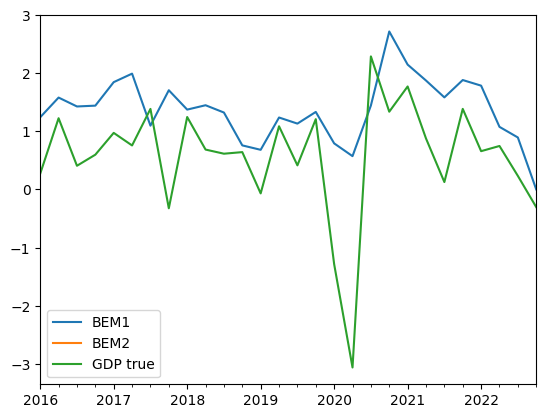

In [33]:
predNow.plot()
None

In [34]:
mean_absolute_error(predNow['GDP true'], predNow['BEM1'])

0.8840411252790036

In [35]:
pred1qa['GDP true'] = np.log(convertToQuarterlyMean(fullData['GDP(SA)'])).diff()*100

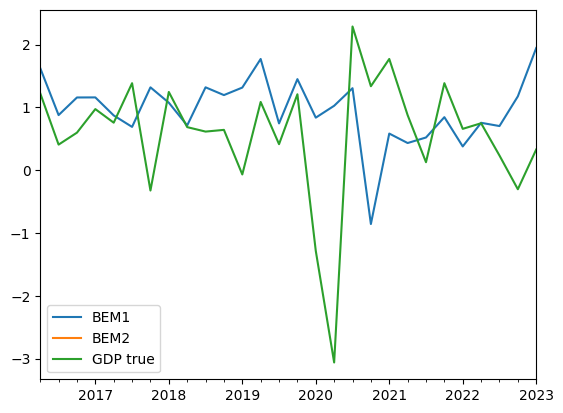

In [36]:
pred1qa.plot()
None

# Test

In [ ]:
from google.colab import files
files.upload()

Saving 2024-01-04.csv to 2024-01-04.csv


{'2024-01-04.csv': b',GDP(SA),\xec\x88\x98\xec\xb6\x9c(NSA),\xec\x88\x98\xec\x9e\x85(NSA),\xec\x86\x8c\xeb\xb9\x84\xec\x9e\x90\xeb\xac\xbc\xea\xb0\x80\xec\xa7\x80\xec\x88\x98(NSA),NSI,\xec\xa0\x84\xec\x82\xb0\xec\x97\x85\xec\x83\x9d\xec\x82\xb0\xec\xa7\x80\xec\x88\x98(SA),\xec\x9d\xbc\xed\x8f\x89\xea\xb7\xa0\xec\x88\x98\xec\xb6\x9c(NSA),\xec\x9d\xbc\xed\x8f\x89\xea\xb7\xa0\xec\x88\x98\xec\x9e\x85(NSA),\xec\x9d\xbc\xed\x8f\x89\xea\xb7\xa0\xec\x88\x98\xec\xb6\x9c(SA),\xec\x9d\xbc\xed\x8f\x89\xea\xb7\xa0\xec\x88\x98\xec\x9e\x85(SA),\xec\x86\x8c\xeb\xb9\x84\xec\x9e\x90\xeb\xac\xbc\xea\xb0\x80\xec\xa7\x80\xec\x88\x98(SA),"\xec\x9d\xbc\xed\x8f\x89\xea\xb7\xa0\xec\x88\x98\xec\xb6\x9c(\xec\x8b\xa4\xec\xa7\x88, SA)"\r\n200001,,12162425.0,12594623.0,62.456,,52.5,511026.26050420164,529185.8403361344,536977.571058137,532463.900964831,62.6159275774485,857573.4510903143\r\n200002,,12676042.0,12023652.0,62.647,,52.5,573576.5610859728,544056.6515837103,576738.790339321,523585.471625166,62.631155775193

In [ ]:
data = pd.read_csv('2024-01-04.csv', index_col=0)

In [ ]:
data.index = pd.PeriodIndex(data.index, freq='M')

In [ ]:
data = data[['GDP(SA)', '전산업생산지수(SA)', '일평균수출(실질, SA)', 'NSI']]

In [ ]:
data

,GDP(SA),전산업생산지수(SA),"일평균수출(실질, SA)",NSI
2000-01,NaN,52.5,8.575735e+05,NaN
2000-02,NaN,52.5,9.208497e+05,NaN
2000-03,220786.3,53.6,9.157984e+05,NaN
2000-04,NaN,53.5,9.982122e+05,NaN
2000-05,NaN,54.9,1.010233e+06,NaN
...,...,...,...,...
2023-09,500277.3,113.0,2.123454e+06,100.78
2023-10,NaN,111.0,2.120541e+06,95.52
2023-11,NaN,111.6,2.145067e+06,102.34
2023-12,NaN,NaN,2.269058e+06,103.33


In [ ]:
end = '2023Q4'

In [ ]:
bem1(data, end).diff()*100

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2651: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'


                                       Dynamic Factor Results                                      
Dep. Variable:     ['전산업생산지수(SA)', '일평균수출(실질, SA)', 'NSI']   No. Observations:                  284
Model:                                Dynamic Factor Model   Log Likelihood                -891.806
                                   + 1 factors in 1 blocks   AIC                           1807.612
                                     + AR(1) idiosyncratic   BIC                           1851.400
Date:                                     Tue, 09 Jan 2024   HQIC                          1825.167
Time:                                             11:22:47   EM Iterations                        2
Sample:                                         06-30-2000                                         
                                              - 01-31-2024                                         
Covariance Type:                              Not computed                                         


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2000Q1         NaN
2000Q2    1.323710
2000Q3    2.717335
2000Q4   -0.324985
2001Q1    1.218106
            ...   
2022Q4   -0.303428
2023Q1    0.329332
2023Q2    0.606808
2023Q3    0.614183
2023Q4    1.175666
Freq: Q-DEC, Name: GDP(SA), Length: 96, dtype: float64

2000Q1    220786.30000
2000Q2    223728.30000
2000Q3    229891.10000
2000Q4    229145.20000
2001Q1    231953.50000
              ...     
2022Q4    492581.20000
2023Q1    494206.10000
2023Q2    497214.10000
2023Q3    500277.30000
2023Q4    506193.59913
Freq: Q-DEC, Name: GDP(SA), Length: 96, dtype: float64

## Calculate Factors

In [ ]:
target, Xs = data['GDP(SA)'], data.drop(columns=['GDP(SA)'])

In [ ]:
target

2000-01         NaN
2000-02         NaN
2000-03    220786.3
2000-04         NaN
2000-05         NaN
             ...   
2023-09    500277.3
2023-10         NaN
2023-11         NaN
2023-12         NaN
2024-01         NaN
Freq: M, Name: GDP(SA), Length: 289, dtype: float64

In [ ]:
Xs

,전산업생산지수(SA),"일평균수출(실질, SA)",NSI
2000-01,52.5,8.575735e+05,NaN
2000-02,52.5,9.208497e+05,NaN
2000-03,53.6,9.157984e+05,NaN
2000-04,53.5,9.982122e+05,NaN
2000-05,54.9,1.010233e+06,NaN
...,...,...,...
2023-09,113.0,2.123454e+06,100.78
2023-10,111.0,2.120541e+06,95.52
2023-11,111.6,2.145067e+06,102.34
2023-12,NaN,2.269058e+06,103.33


In [ ]:
filteredObserved = hamiltonFilterDF(np.log(Xs)).iloc[5:]
filteredObserved

,전산업생산지수(SA),"일평균수출(실질, SA)",NSI
2000-06,0.014985,0.046654,NaN
2000-07,0.023870,0.008494,NaN
2000-08,-0.000465,-0.035211,NaN
2000-09,-0.016797,0.011769,NaN
2000-10,-0.028051,-0.078254,NaN
...,...,...,...
2023-09,0.018354,0.014412,0.003528
2023-10,0.007154,0.038830,-0.053081
2023-11,-0.001541,0.044678,0.031473
2023-12,NaN,0.066546,0.032516


<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*a

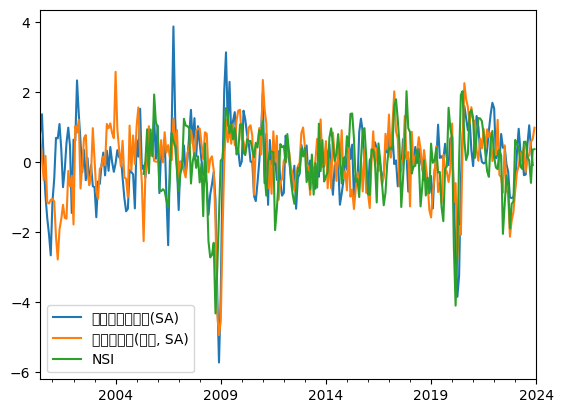

In [ ]:
(filteredObserved / filteredObserved.std()).plot()

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*a

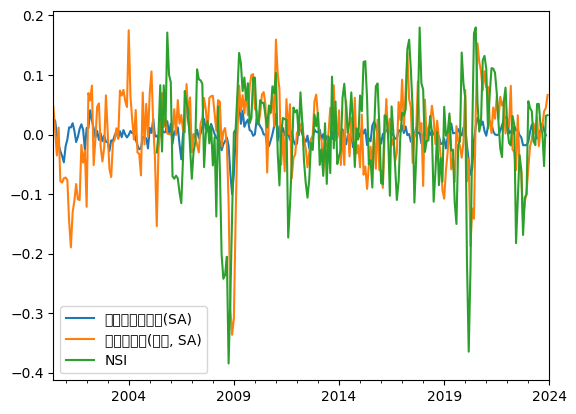

In [ ]:
filteredObserved.plot()

In [ ]:
factors = kalmanState(data=filteredObserved, end=end)
factors

                                       Dynamic Factor Results                                      
Dep. Variable:     ['전산업생산지수(SA)', '일평균수출(실질, SA)', 'NSI']   No. Observations:                  284
Model:                                Dynamic Factor Model   Log Likelihood                -891.806
                                   + 1 factors in 1 blocks   AIC                           1807.612
                                     + AR(1) idiosyncratic   BIC                           1851.400
Date:                                     Tue, 09 Jan 2024   HQIC                          1825.167
Time:                                             10:46:49   EM Iterations                        2
Sample:                                         06-30-2000                                         
                                              - 01-31-2024                                         
Covariance Type:                              Not computed                                         


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2651: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'


,Factor
2000-06,-1.216876
2000-07,-0.999711
2000-08,0.073109
2000-09,0.768430
2000-10,1.812545
...,...
2023-08,-0.380449
2023-09,-0.652252
2023-10,-0.427956
2023-11,-0.467014


In [ ]:
querterlyFactors = convertToQuarterlyMean(factors)
querterlyFactors

,Factor
2000Q2,-1.216876
2000Q3,-0.052724
2000Q4,2.177082
2001Q1,1.077022
2001Q2,0.536805
...,...
2022Q4,1.794663
2023Q1,-0.042949
2023Q2,-0.198055
2023Q3,-0.337082


In [ ]:
logTarget = np.log(target)
querterlyLogTarget = convertToQuarterlyMean(logTarget)
querterlyLogTarget = querterlyLogTarget.reindex(pd.period_range(start='2000Q1', end=end, freq='Q-DEC'))

In [ ]:
querterlyLogTarget

2000Q1    12.304951
2000Q2    12.318188
2000Q3    12.345361
2000Q4    12.342111
2001Q1    12.354292
            ...    
2022Q4    13.107415
2023Q1    13.110708
2023Q2    13.116776
2023Q3    13.122918
2023Q4          NaN
Freq: Q-DEC, Name: GDP(SA), Length: 96, dtype: float64

In [ ]:
targetARresult = ARIMA(endog=querterlyLogTarget, order=(2,0,0), trend='ct', enforce_stationarity=False, enforce_invertibility=False).fit()
targetARresult.summary()
# uARresult = ARIMA(endog=targetARresult.resid.loc['2001Q1':], exog=querterlyFactors.loc['2001Q1':], order=(1,0,0), trend='n').fit()
# finalTargetPredict = targetARresult.predict(start='2016Q1', end=end) + uARresult.predict(start='2016Q1', end=end)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                GDP(SA)   No. Observations:                   96
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 308.506
Date:                Tue, 09 Jan 2024   AIC                           -607.011
Time:                        10:56:14   BIC                           -594.295
Sample:                    03-31-2000   HQIC                          -601.875
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5163      0.134     93.672      0.000      12.254      12.778
x1             0.0065      0.002      4.153      0.000       0.003       0.010
ar.L1          1.0851      0.089     12.129      0.000       0.910       1.260
ar.L2         -0.1309      0.093     -1.412      0.158      -0.313       0.051
sigma2      7.686e-05   7.64e-06     10.064      0.000    6.19e-05    9.18e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               219.77
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                            -1.78
Prob(H) (two-sided):                  0.41   Kurtosis:                         9.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

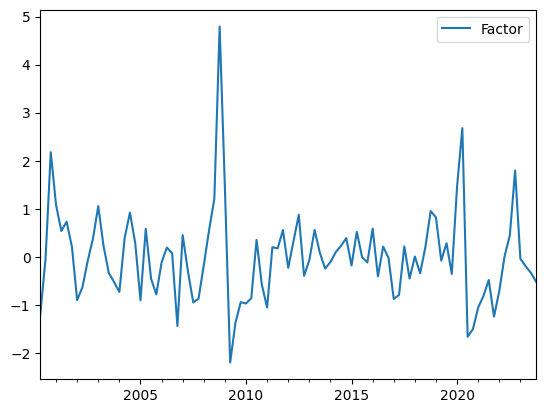

In [ ]:
querterlyFactors.plot()

In [ ]:
uARresult = ARIMA(endog=targetARresult.resid.loc['2001Q1':], exog=querterlyFactors.loc['2001Q1':], order=(1,0,0), trend='n').fit()

In [ ]:
uARresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   92
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 343.863
Date:                Tue, 09 Jan 2024   AIC                           -681.725
Time:                        10:58:33   BIC                           -674.160
Sample:                    03-31-2001   HQIC                          -678.672
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Factor        -0.0067      0.000    -15.190      0.000      -0.008      -0.006
ar.L1         -0.3309      0.097     -3.410      0.001      -0.521      -0.141
sigma2      3.051e-05   4.71e-06      6.482      0.000    2.13e-05    3.97e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.72
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.84
Prob(H) (two-sided):                  0.58   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
finalTargetPredict = targetARresult.predict(start='2016Q1', end=end) + uARresult.predict(start='2016Q1', end=end)

In [ ]:
finalTargetPredict

2016Q1    12.950722
2016Q2    12.959245
2016Q3    12.967238
2016Q4    12.973581
2017Q1    12.985190
2017Q2    12.995453
2017Q3    12.996517
2017Q4    13.010924
2018Q1    13.010117
2018Q2    13.019908
2018Q3    13.025528
2018Q4    13.025340
2019Q1    13.030920
2019Q2    13.038357
2019Q3    13.046079
2019Q4    13.055618
2020Q1    13.054742
2020Q2    13.035810
2020Q3    13.036228
2020Q4    13.056066
2021Q1    13.069707
2021Q2    13.082900
2021Q3    13.090602
2021Q4    13.097583
2022Q1    13.106453
2022Q2    13.108871
2022Q3    13.111245
2022Q4    13.104773
2023Q1    13.112467
2023Q2    13.119697
2023Q3    13.126837
2023Q4    13.134674
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [ ]:
hamiltonFilter(log(Xs))

,전산업생산지수(SA),"일평균수출(실질, SA)",NSI
2000-01,NaN,NaN,NaN
2000-02,NaN,NaN,NaN
2000-03,NaN,NaN,NaN
2000-04,NaN,NaN,NaN
2000-05,NaN,NaN,NaN
...,...,...,...
2023-09,NaN,NaN,NaN
2023-10,NaN,NaN,NaN
2023-11,NaN,NaN,NaN
2023-12,NaN,NaN,NaN


### Hamilton Filter

In [ ]:
filteredObserved = hamiltonFilter(log(Xs)).iloc[3:]

In [ ]:
filteredObserved

,전산업생산지수(SA),"일평균수출(실질, SA)",NSI
2000-04,1.886848,15.244648,NaN
2000-05,4.470018,9.273407,NaN
2000-06,2.760065,7.740964,NaN
2000-07,4.029849,3.315677,NaN
2000-08,1.086967,-0.824239,NaN
...,...,...,...
2023-03,1.998250,-1.717768,12.157326
2023-04,0.823803,1.896752,1.313439
2023-05,0.995033,0.555171,-0.989699
2023-06,0.009982,3.198122,7.633550


<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


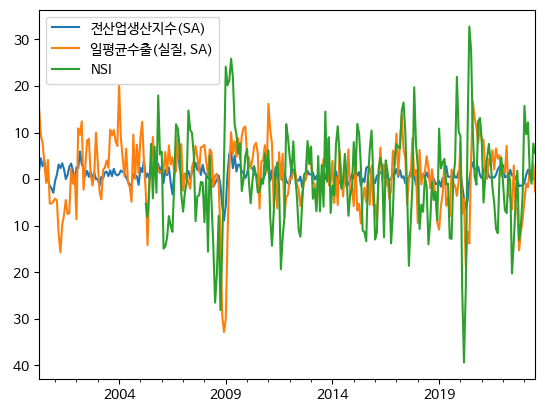

In [ ]:
filteredObserved.plot()

### Kalman

In [ ]:
def kalmanState(data: pd.DataFrame, end:str) -> np.ndarray:
  mod = DynamicFactorMQ(data, factor_orders=2)
  res = mod.fit()
  # print(res.summary())
  factors = copy.deepcopy(res.factors['smoothed'])
  factors.columns = ['Factor']
  factors = factors.reindex(pd.period_range(start=factors.index[0], end=pd.Period(end, freq='Q-DEC'), freq='M'))
  for i in range(len(factors)):
    if np.isnan(factors['Factor'].iloc[i]):
      factors['Factor'].iloc[i] = res.params['L1.0->0'] * factors['Factor'].iloc[i - 1] + res.params['L2.0->0'] * factors['Factor'].iloc[i - 2]
  return factors

In [ ]:
factors = kalmanState(data=filteredObserved, end=end)

                                       Dynamic Factor Results                                      
Dep. Variable:     ['전산업생산지수(SA)', '일평균수출(실질, SA)', 'NSI']   No. Observations:                  280
Model:                                Dynamic Factor Model   Log Likelihood                -910.780
                                   + 1 factors in 1 blocks   AIC                           1845.559
                                     + AR(1) idiosyncratic   BIC                           1889.177
Date:                                     Fri, 04 Aug 2023   HQIC                          1863.055
Time:                                             00:49:45   EM Iterations                       41
Sample:                                         04-30-2000                                         
                                              - 07-31-2023                                         
Covariance Type:                              Not computed                                         


In [ ]:
factors

,Factor
2000-04,-2.539684
2000-05,-2.715638
2000-06,-2.062890
2000-07,-1.321023
2000-08,-0.279419
...,...
2023-08,0.328196
2023-09,0.221708
2023-10,0.088379
2023-11,-0.013765


<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


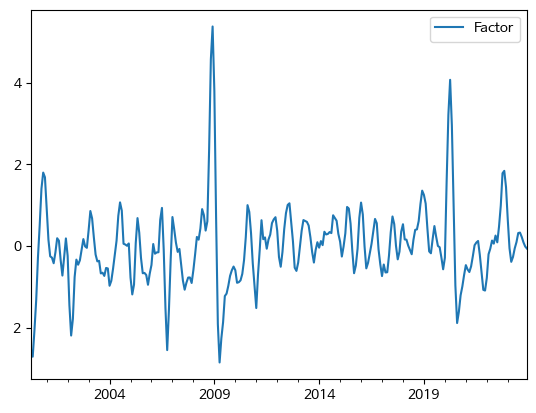

In [ ]:
factors.plot()

In [ ]:
querterlyFactors = convertToQuarterlyMean(factors)

In [ ]:
querterlyFactors

,Factor
2000Q2,-2.439404
2000Q3,-0.363265
2000Q4,1.629845
2001Q1,0.270284
2001Q2,-0.288249
...,...
2022Q4,1.690615
2023Q1,0.067285
2023Q2,-0.076691
2023Q3,0.289052


<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


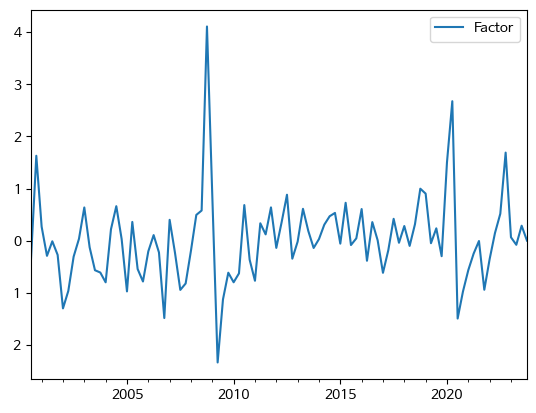

In [ ]:
querterlyFactors.loc['2000Q3':].plot()

## BEM

In [ ]:
target

,GDP(SA)
2000-01,NaN
2000-02,NaN
2000-03,220786.3
2000-04,NaN
2000-05,NaN
...,...
2023-03,494206.1
2023-04,NaN
2023-05,NaN
2023-06,497114.1


In [ ]:
logTarget = log(target)

In [ ]:
querterlyLogTarget = convertToQuarterlyMean(logTarget)

In [ ]:
querterlyLogTarget = querterlyLogTarget.reindex(pd.period_range(start=factors.index[0], end=end, freq='Q-DEC'))

In [ ]:
querterlyLogTarget

,GDP(SA)
2000Q2,1231.818765
2000Q3,1234.536100
2000Q4,1234.211114
2001Q1,1235.429220
2001Q2,1236.719738
...,...
2022Q4,1310.741460
2023Q1,1311.070792
2023Q2,1311.657486
2023Q3,NaN


### BEM1

#### GDP AR(2)

In [ ]:
targetARresult = ARIMA(endog=querterlyLogTarget.loc['2000Q3':], order=(2,0,0), trend='ct', enforce_stationarity=False, enforce_invertibility=False).fit()

In [ ]:
targetARresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                GDP(SA)   No. Observations:                   94
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -113.588
Date:                Fri, 04 Aug 2023   AIC                            237.176
Time:                        00:50:18   BIC                            249.785
Sample:                    09-30-2000   HQIC                           242.265
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1250.3412     10.250    121.989      0.000    1230.252    1270.430
x1             0.6866      0.133      5.176      0.000       0.427       0.947
ar.L1          1.1228      0.088     12.706      0.000       0.950       1.296
ar.L2         -0.1788      0.104     -1.722      0.085      -0.382       0.025
sigma2         0.7307      0.078      9.386      0.000       0.578       0.883
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               256.07
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -1.80
Prob(H) (two-sided):                  0.08   Kurtosis:                        10.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
targetARresult.predict(start='2023Q2', end=end)

2023Q2    1311.791508
2023Q3    1312.429804
2023Q4    1313.230513
Freq: Q-DEC, Name: predicted_mean, dtype: float64

#### U_t

In [ ]:
targetARresult.resid

2000Q3   -16.491667
2000Q4     1.014139
2001Q1    -0.266935
2001Q2    -0.440664
2001Q3    -0.369180
            ...    
2022Q4    -0.931623
2023Q1    -0.258269
2023Q2    -0.134022
2023Q3          NaN
2023Q4          NaN
Freq: Q-DEC, Length: 94, dtype: float64

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


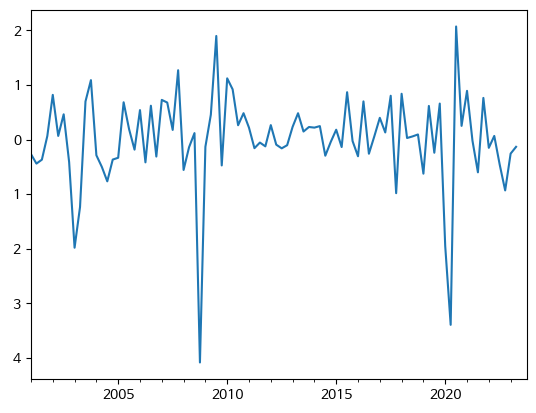

In [ ]:
targetARresult.resid.loc['2001Q1':].plot()

In [ ]:
uARresult = ARIMA(endog=targetARresult.resid.loc['2001Q1':], exog=querterlyFactors.loc['2001Q1':], order=(1,0,0), trend='n').fit()

In [ ]:
uARresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   92
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -80.808
Date:                Fri, 04 Aug 2023   AIC                            167.616
Time:                        00:50:27   BIC                            175.182
Sample:                    03-31-2001   HQIC                           170.670
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Factor        -0.7209      0.046    -15.768      0.000      -0.810      -0.631
ar.L1         -0.2248      0.091     -2.468      0.014      -0.403      -0.046
sigma2         0.3525      0.054      6.556      0.000       0.247       0.458
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 9.78
Prob(Q):                              0.82   Prob(JB):                         0.01
Heteroskedasticity (H):               0.60   Skew:                            -0.76
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
uARresult.predict(start='2023Q2', end=end)

2023Q2    0.102444
2023Q3   -0.165814
2023Q4   -0.012090
Freq: Q-DEC, Name: predicted_mean, dtype: float64

#### Final result

In [ ]:
finalTargetPredict = targetARresult.predict(start='2023Q2', end=end) + uARresult.predict(start='2023Q2', end=end)

In [ ]:
finalTargetPredict

2023Q2    1311.893952
2023Q3    1312.263990
2023Q4    1313.218422
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [ ]:
np.exp(finalTargetPredict/100)

2023Q2    498290.999139
2023Q3    500138.279542
2023Q4    504934.613824
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [ ]:
finalTargetPredict.loc['2023Q2'] - querterlyLogTarget.loc['2023Q1']

GDP(SA)    0.823161
Name: 2023Q1, dtype: float64

In [ ]:
finalTargetPredict.loc['2023Q3'] - querterlyLogTarget.loc['2023Q2']

GDP(SA)    0.606504
Name: 2023Q2, dtype: float64

In [ ]:
finalTargetPredict.loc['2023Q4'] - finalTargetPredict.loc['2023Q3']

0.9544324046044039

### BEM2

#### GDP AR(2) + factor exog

In [ ]:
targetARresult = ARIMA(endog=querterlyLogTarget.loc['2000Q3':], exog=querterlyFactors.loc['2000Q3':], order=(2,0,0), trend='ct', enforce_stationarity=False, enforce_invertibility=False).fit()

In [ ]:
targetARresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                GDP(SA)   No. Observations:                   94
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -106.564
Date:                Fri, 04 Aug 2023   AIC                            225.127
Time:                        00:51:46   BIC                            240.258
Sample:                    09-30-2000   HQIC                           231.234
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1250.4760     10.499    119.103      0.000    1229.898    1271.054
drift          0.6850      0.132      5.179      0.000       0.426       0.944
Factor        -0.3042      0.062     -4.932      0.000      -0.425      -0.183
ar.L1          1.2068      0.102     11.860      0.000       1.007       1.406
ar.L2         -0.2550      0.103     -2.480      0.013      -0.456      -0.054
sigma2         0.6252      0.068      9.219      0.000       0.492       0.758
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                73.01
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.90
Prob(H) (two-sided):                  0.60   Kurtosis:                         6.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
targetARresult.predict(start='2023Q2', end=end)

2023Q2    1311.666010
2023Q3    1312.284871
2023Q4    1313.157742
Freq: Q-DEC, Name: predicted_mean, dtype: float64

#### U_t

In [ ]:
targetARresult.resid

2000Q3   -16.735465
2000Q4     3.058027
2001Q1    -0.602940
2001Q2    -0.414466
2001Q3    -0.168733
            ...    
2022Q4    -0.557234
2023Q1    -0.730534
2023Q2    -0.008525
2023Q3          NaN
2023Q4          NaN
Freq: Q-DEC, Length: 94, dtype: float64

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


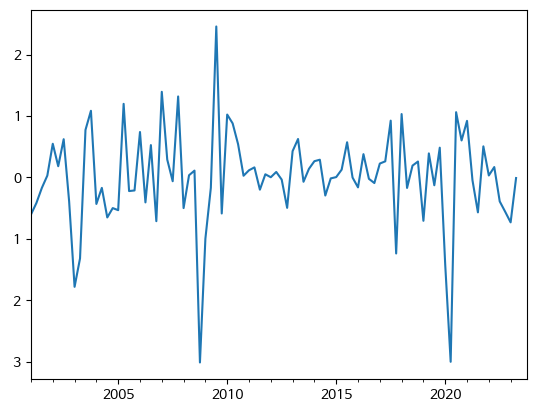

In [ ]:
targetARresult.resid.loc['2001Q1':].plot()

In [ ]:
uARresult = ARIMA(endog=targetARresult.resid.loc['2001Q1':], order=(2,0,0), trend='n').fit()

In [ ]:
uARresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   92
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -106.239
Date:                Fri, 04 Aug 2023   AIC                            218.477
Time:                        00:51:52   BIC                            226.042
Sample:                    03-31-2001   HQIC                           221.530
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0190      0.088      0.217      0.829      -0.153       0.191
ar.L2         -0.0828      0.115     -0.718      0.473      -0.309       0.143
sigma2         0.6205      0.060     10.385      0.000       0.503       0.738
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                65.78
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.88
Prob(H) (two-sided):                  0.60   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
uARresult.predict(start='2023Q2', end=end)

2023Q2    0.032268
2023Q3    0.060343
2023Q4    0.001853
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [ ]:
uARresult.resid

2001Q1   -0.602940
2001Q2   -0.403884
2001Q3   -0.210794
2001Q4   -0.000127
2002Q1    0.534853
            ...   
2022Q4   -0.535755
2023Q1   -0.752161
2023Q2   -0.040793
2023Q3         NaN
2023Q4         NaN
Freq: Q-DEC, Length: 92, dtype: float64

#### Final result

In [ ]:
finalTargetPredict = targetARresult.predict(start='2023Q2', end=end) + uARresult.predict(start='2023Q2', end=end)

In [ ]:
finalTargetPredict

2023Q2    1311.698278
2023Q3    1312.345214
2023Q4    1313.159595
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [ ]:
np.exp(finalTargetPredict/100)

2023Q2    497316.927623
2023Q3    500544.678122
2023Q4    504637.662183
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [ ]:
finalTargetPredict.loc['2023Q2'] - querterlyLogTarget.loc['2023Q1']

GDP(SA)    0.627487
Name: 2023Q1, dtype: float64

In [ ]:
finalTargetPredict.loc['2023Q3'] - finalTargetPredict.loc['2023Q2']

0.6469357549842698

In [ ]:
finalTargetPredict.loc['2023Q4'] - finalTargetPredict.loc['2023Q3']

0.8143809373493696